In [1]:
# General
import os, time
import requests, glob, warnings
import numpy as np
import pandas as pd
import datetime as dt
import tables as tb
pd.options.display.max_columns = 24

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Cartopy & geopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from geopy import distance

In [2]:
%config Completer.use_jedi = False

# Chicago taxi

Raw data summary:
- **Number of files and size**: 74GB in 8 files.
- **Time span**: 2013 - 2020.
- **Total number of trips**: > 193 M.
- **Total number of zones**: 801.

## Fetching the data

Started download on the 18th of June 2020:

In [18]:
url_d = {
    2013: 'https://data.cityofchicago.org/api/views/6h2x-drp2/rows.csv?accessType=DOWNLOAD',
    2014: 'https://data.cityofchicago.org/api/views/66as-63gf/rows.csv?accessType=DOWNLOAD',
    2015: 'https://data.cityofchicago.org/api/views/9arg-bn2i/rows.csv?accessType=DOWNLOAD',
    2016: 'https://data.cityofchicago.org/api/views/bk5j-9eu2/rows.csv?accessType=DOWNLOAD',
    2017: 'https://data.cityofchicago.org/api/views/jeij-fq8w/rows.csv?accessType=DOWNLOAD',
    2018: 'https://data.cityofchicago.org/api/views/vbsw-zws8/rows.csv?accessType=DOWNLOAD',
    2019: 'https://data.cityofchicago.org/api/views/h4cq-z3dy/rows.csv?accessType=DOWNLOAD',
    2020: 'https://data.cityofchicago.org/api/views/r2u4-wwk3/rows.csv?accessType=DOWNLOAD',
}

In [7]:
for year in url_d.keys():
    print('Fechting {}...'.format(year))
    r = requests.get(url_d[year])
    if r.status_code == 200:    
        with open('../data/chicago/raw/{}_taxi.csv'.format(year), 'wb') as f:
            f.write(r.content)

Fechting 2013...
Fechting 2014...
Fechting 2015...
Fechting 2016...
Fechting 2017...
Fechting 2018...
Fechting 2019...
Fechting 2020...


On the 5th of May 2021, we downloaded again data for year 2020 (it wasn't full):

In [4]:
for year in [2020]:
    print('Fechting {}...'.format(year))
    r = requests.get(url_d[year])
    if r.status_code == 200:    
        with open('../data/chicago/raw/{}_taxi.csv'.format(year), 'wb') as f:
            f.write(r.content)

Fechting 2020...


In [7]:
!ls ../data/chicago/raw/*taxi.csv | wc -l

8


In [10]:
!du -h ../data/chicago/raw/*taxi*

11G	../data/chicago/raw/2013_taxi.csv
15G	../data/chicago/raw/2014_taxi.csv
13G	../data/chicago/raw/2015_taxi.csv
13G	../data/chicago/raw/2016_taxi.csv
9.7G	../data/chicago/raw/2017_taxi.csv
8.1G	../data/chicago/raw/2018_taxi.csv
6.5G	../data/chicago/raw/2019_taxi.csv
1.5G	../data/chicago/raw/2020_taxi.csv
1.2G	../data/chicago/raw/2020_taxi_OLD.csv


In [11]:
!head -1 ../data/chicago/raw/2019_taxi.csv

Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid  Location


In [19]:
df_colnames = pd.DataFrame(columns=['shape', 'columns', 'n_pickup', 'n_dropoff',
                                    'pickup_long_min', 'pickup_long_max', 'pickup_lat_min', 'pickup_lat_max',
                                    'dropoff_long_min', 'dropoff_long_max', 'dropoff_lat_min', 'dropoff_lat_max'])
for year in url_d.keys():
    df = pd.read_csv('../data/chicago/raw/{}_taxi.csv'.format(year))
    df_colnames.loc[year, 'shape'] = str(df.shape)
    df_colnames.loc[year, 'columns'] = str(df.columns.values)
    df_colnames.loc[year, 'n_pickup'] = df['Pickup Centroid Location'].nunique()
    df_colnames.loc[year, 'n_dropoff'] = df['Dropoff Centroid  Location'].nunique()
    # Pick-up
    df_colnames.loc[year, 'pickup_long_min'] = df['Pickup Centroid Longitude'].min()
    df_colnames.loc[year, 'pickup_long_max'] = df['Pickup Centroid Longitude'].max()
    df_colnames.loc[year, 'pickup_lat_min'] = df['Pickup Centroid Latitude'].min()
    df_colnames.loc[year, 'pickup_lat_max'] = df['Pickup Centroid Latitude'].max()
    # Drop-off
    df_colnames.loc[year, 'dropoff_long_min'] = df['Dropoff Centroid Longitude'].min()
    df_colnames.loc[year, 'dropoff_long_max'] = df['Dropoff Centroid Longitude'].max()
    df_colnames.loc[year, 'dropoff_lat_min'] = df['Dropoff Centroid Latitude'].min()
    df_colnames.loc[year, 'dropoff_lat_max'] = df['Dropoff Centroid Latitude'].max()
    
    print('{} -> {}'.format(year, df.shape))

2013 -> (27217716, 23)
2014 -> (37395436, 23)
2015 -> (32385875, 23)
2016 -> (31759339, 23)
2017 -> (24988003, 23)
2018 -> (20732088, 23)
2019 -> (16477365, 23)
2020 -> (3889032, 23)


New 2020 dataset has 3889032 rows, compared to 2880334 from before (1008698 more).

In [21]:
df_colnames

,shape,columns,n_pickup,n_dropoff,pickup_long_min,pickup_long_max,pickup_lat_min,pickup_lat_max,dropoff_long_min,dropoff_long_max,dropoff_lat_min,dropoff_lat_max
2013,"(27217716, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,668,740,-87.913625,-87.530712,41.660136,42.021224,-87.913625,-87.530712,41.651922,42.021224
2014,"(37395436, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,712,769,-87.913625,-87.534903,41.660136,42.021224,-87.913625,-87.534903,41.660136,42.021224
2015,"(32385875, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,617,698,-87.913625,-87.534903,41.660136,42.021224,-87.913625,-87.531386,41.660136,42.021224
2016,"(31759339, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,693,768,-87.913625,-87.531386,41.660136,42.021224,-87.913625,-87.531386,41.660136,42.021224
2017,"(24988003, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,646,734,-87.913625,-87.529950,41.660136,42.021224,-87.913625,-87.529950,41.660136,42.021224
2018,"(20732088, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,610,703,-87.913625,-87.534903,41.650222,42.021224,-87.913625,-87.531386,41.650222,42.021224
2019,"(16477365, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,668,780,-87.913625,-87.530712,41.660136,42.021224,-87.913625,-87.530712,41.660136,42.021224
2020,"(3889032, 23)",['Trip ID' 'Taxi ID' 'Trip Start Timestamp' 'T...,575,647,-87.913625,-87.531386,41.650222,42.021224,-87.913625,-87.531386,41.660136,42.021224


In [22]:
df_colnames.to_excel('../data/chicago/other/colnames-taxi.xlsx')

194M of entries in total:

In [24]:
sum([eval(df_colnames.loc[year, 'shape'])[0] for year in url_d.keys()])

194844854

All columns are named the same (bravo Chicago):

In [25]:
df_colnames['columns'].nunique()

1

**Caveat**:
- Notice that the drop-off location column name has an extra space! `'Dropoff Centroid  Location'`
- Notice also that column types need to be specified when reading the `csv`s.

## Process and transfer trip counts

### Build new dataset

The final file will look like this:
```
chicago.h5 (file)
|-- years (carray) -> trips count: time (rows) + zones (columns)
```

In [19]:
from shapely.wkt import loads as load_wkt

In [4]:
def zone_lookup(loc, poly_d):
    if loc is np.nan:
        return np.nan
    for key in poly_d.keys():
        if poly_d[key].contains(load_wkt(loc)):
            return key
    return np.nan

def filter_pivot(df, poly_d, ttype, year):
    df_zone = pd.DataFrame()
    location = 'Pickup Centroid Location' if ttype == 'pu' else 'Dropoff Centroid  Location'
    timestamp = 'Trip Start Timestamp' if ttype == 'pu' else 'Trip End Timestamp'
    df_zone[ttype + '_location'] = df[location].unique()
    df_zone.loc[:, ttype + '_zone'] = df_zone[ttype + '_location'].apply(zone_lookup, poly_d=poly_d)
    df = pd.merge(df, df_zone, left_on=location, right_on=ttype + '_location')
    df_pivot = df[[timestamp, ttype + '_zone']].pivot_table(index=timestamp, columns=ttype + '_zone',
                                                                aggfunc=len, fill_value=0)
    missing = set(poly_d.keys()).difference(set(df_pivot.columns.values))
    for m in missing:
        df_pivot.loc[:, m] = 0
    colnames = sorted(df_pivot.columns.values)
    df_pivot = df_pivot[colnames]
    df_pivot = df_pivot.resample('15min').first().fillna(0).astype('int16')
    return df_pivot['{:04}0101'.format(year):'{:04}1231'.format(year)], colnames    

def transfer_raw(in_path, out_path, coltypes, ttype='pu'):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Int16Atom()
    # Prepare zones
    df_lu = pd.read_csv(os.path.join('../data/chicago/other/zone-lookup-taxi.csv'))
    poly_d = dict()
    for r in df_lu.iterrows():
        poly = r[1]['the_geom']
        zone = r[1]['NAME10']
        poly_d[zone] = load_wkt(poly)
    tic = time.time()
    df_full = pd.DataFrame()
    for year in url_d.keys():
        file = in_path.format(year)
        print('Working on {}...'.format(year))
        df = pd.read_csv(file, dtype=coltypes)
        # Convert to datetime
        df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])
        df['Trip End Timestamp'] = pd.to_datetime(df['Trip End Timestamp'])
        # Filter trips outside the zones and pivot
        df_pivot, colnames = filter_pivot(df, poly_d, ttype, year)
        df_full = pd.concat([df_full, df_pivot])
    # Open file and transfer
    with tb.open_file(out_path, mode='a', filters=filters) as hdf5_file, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        node = hdf5_file.create_carray(obj=df_full.values, atom=dtype,
                                       where='/', name='2013')
        # Add meta: column names
        node._v_attrs['columns'] = colnames
        node._v_attrs['time_resolution'] = '15min'
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [5]:
coltypes = {
    'Trip ID': object,
    'Taxi ID': object,
    'Trip Start Timestamp': object,
    'Trip End Timestamp': object,
    'Trip Seconds': float,
    'Trip Miles': float,
    'Pickup Census Tract': float,
    'Dropoff Census Tract': float,
    'Pickup Community Area': float,
    'Dropoff Community Area': float,
    'Fare': float,
    'Tips': float,
    'Tolls': float,
    'Extras': float,
    'Trip Total': float,
    'Payment Type': object,
    'Company': object,
    'Pickup Centroid Latitude': float,
    'Pickup Centroid Longitude': float,
    'Pickup Centroid Location': object,
    'Dropoff Centroid Latitude': float,
    'Dropoff Centroid Longitude': float,
    'Dropoff Centroid  Location': object
}

In [99]:
in_path = '../data/chicago/raw/{}_taxi.csv'
out_path = '../data/chicago/clean/15m_flat_taxi_count.h5'
transfer_raw(in_path, out_path, coltypes)

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...

It took 10:54:43 in total


### Sanity checks

Helper functions:

In [3]:
def idx_to_datetime(idx, year, freq=15):
    # Frequency expressed in minutes
    base = dt.datetime(year, 1, 1, 0, 0)
    return base + dt.timedelta(minutes=freq * idx)

In [4]:
idx_to_datetime(520, 2020)

datetime.datetime(2020, 1, 6, 10, 0)

In [5]:
def datetime_to_idx(date, freq=15):
    # Frequency expressed in minutes
    base = dt.datetime(date.year, 1, 1, 0, 0)
    return int((date - base).total_seconds() / (60 * freq))

In [7]:
datetime_to_idx(dt.datetime(2020, 3, 15, 0, 0))

7104

Trips count:

In [10]:
with tb.open_file(out_path, mode='r') as hdf5_file:
    arr = hdf5_file.get_node('/{:04}'.format(2013))[:]
    print('2013 - 2020 ->', arr.sum())

2013 - 2020 -> 171730414


In [11]:
print('Kept {:0.3}% of the trips'.format(171730414 / 194844854 * 100))

Kept 88.1% of the trips


Some figures:

In [14]:
df_stat = pd.DataFrame(columns=['n_rows', 'n_cols', 'n_entries', 'min', 'max', 'n_zeros', 'n_na'])
with tb.open_file(out_path, mode='r') as hdf5_file:
    for year in [2013]:
        arr = hdf5_file.get_node('/{:04}'.format(year))[:]
        df_stat.loc[year, ['n_rows', 'n_cols']] = arr.shape
        df_stat.loc[year, 'n_entries'] = arr.shape[0] * arr.shape[1]
        df_stat.loc[year, 'min'] = arr.min()
        df_stat.loc[year, 'max'] = arr.max()        
        df_stat.loc[year, 'n_zeros'] = (arr == 0).sum()     
        df_stat.loc[year, 'n_na'] = np.isnan(arr).sum()

#df_stat.loc['total', :] = df_stat.loc[:, :].sum(axis=0)
print('{:0.3}% of the entries are zero'.format(df_stat.loc[2013, 'n_zeros'] / \
                                               df_stat.loc[2013, 'n_entries'] * 100))
df_stat

93.1% of the entries are zero


,n_rows,n_cols,n_entries,min,max,n_zeros,n_na
2013,280512,801,224690112,0,418,209085402,0


Find the max:

In [15]:
with tb.open_file(out_path, mode='r') as hdf5_file:
    year = 2013
    arr = hdf5_file.get_node('/{:04}'.format(year))[:]
i_max, j_max = np.unravel_index(arr.argmax(), arr.shape)
print('max is in ({}, {}) -> {}'.format(i_max, j_max, arr[i_max, j_max]))

max is in (113738, 756) -> 418


In [21]:
idx_to_datetime(int(i_max), 2013).strftime('%d/%m/%Y %H:%M'), sorted(poly_d.keys())[j_max]

('30/03/2016 18:30', 8391.0)

Entries per year (and leap year):

In [22]:
4 * 24 * 365, 4 * 24 * 366

(35040, 35136)

Pick a random instant and check whether the trips count and zone matches the original data:

In [366]:
aux = df_pivot.loc['2020-06-01', :].T
aux[aux['2020-06-01'] != 0]

Trip Start Timestamp,2020-06-01
pu_zone,
5608.0,2
8307.0,2
8329.0,1
8358.0,2


In [369]:
df[df['Trip Start Timestamp'] == '2020-06-01'].iloc[:, -8:]

,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,location,pu_zone
174867,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),POINT (-87.6558787862 41.96581197),8307.0
174868,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),POINT (-87.6558787862 41.96581197),8307.0
236210,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),POINT (-87.7696154528 41.7925923603),5608.0
236211,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),POINT (-87.7696154528 41.7925923603),5608.0
1014287,NaN,NaN,NaN,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),NaN,NaN
1014288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014289,NaN,NaN,NaN,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),NaN,NaN
2232113,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.673820,-87.635740,POINT (-87.6357397768 41.6738199043),POINT (-87.6635175498 41.874005383),8329.0
2707697,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),POINT (-87.6178596758 41.8129489392),8358.0
2707698,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),POINT (-87.6178596758 41.8129489392),8358.0


## Normalise trip counts

$$x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$

### Normalise per zone

#### Compute metrics per zone

In [86]:
df_stand = pd.DataFrame(np.nan, index=sorted(poly_d.keys()), columns=['mean', 'std', 'min', 'max'])
with tb.open_file(out_path, mode='r') as hdf5_file:
    for idx, zone in enumerate(sorted(poly_d.keys())):
        arr = np.empty(0)
        for year in range(2013, 2021):
            arr = np.concatenate((arr, hdf5_file.get_node('/{:04}'.format(year))[:, idx]))
        df_stand.loc[zone] = arr.mean(), arr.std(), arr.min(), arr.max()
df_stand.to_csv('../data/chicago/other/chicago-metrics-per-zone.csv')
display(df_stand.max())
df_stand.idxmax()

mean     75.121830
std      79.782862
min       0.000000
max     418.000000
dtype: float64

mean    8391.0
std     8391.0
min      101.0
max     8391.0
dtype: float64

In [2]:
df_stand = pd.read_csv('../data/chicago/other/chicago-metrics-per-zone.csv', index_col=0)
df_stand.head()

,mean,std,min,max
101.00,0.001181,0.061543,0.0,17.0
102.01,0.002019,0.069837,0.0,6.0
102.02,0.004620,0.098562,0.0,7.0
103.00,0.006162,0.113756,0.0,7.0
104.00,0.005693,0.118841,0.0,7.0


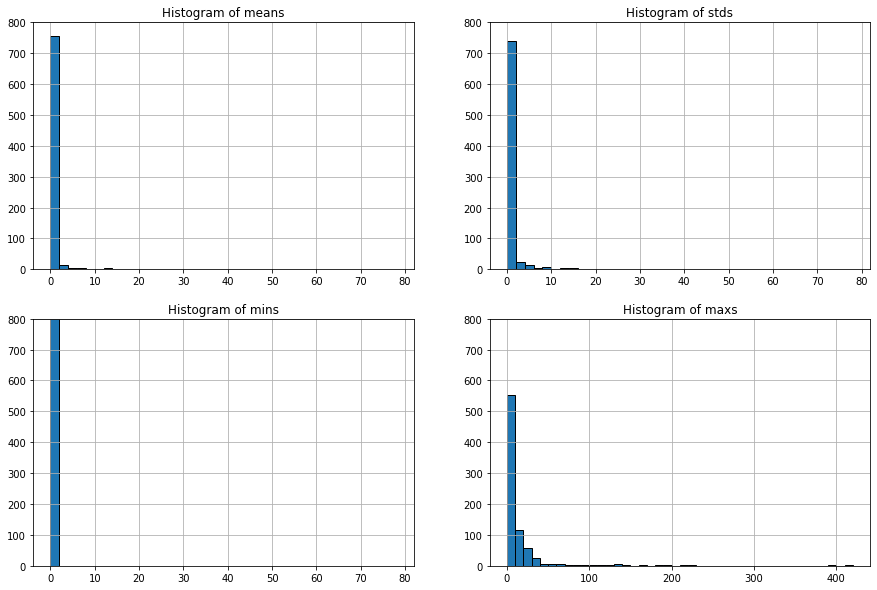

In [81]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
bins_s = np.arange(0, 80, 2)
bins_l = np.arange(0, 425, 10)
axs = axs.ravel()
for idx, col in enumerate(['mean', 'std', 'min', 'max']):
    bins = bins_s if col != 'max' else bins_l
    aux = axs[idx].hist(df_stand[col], bins=bins, edgecolor='k')
    axs[idx].set_title('Histogram of {}s'.format(col))
    axs[idx].grid()
    axs[idx].set_ylim(0, 800)
plt.show()

In [793]:
df_stand[df_stand['min'] != 0].shape[0]

0

Distribution of the maximum per zone:

In [93]:
pd.DataFrame(aux[0].astype(int), columns=['n_zones'],
             index=pd.interval_range(0, 425, freq=10, closed='left'))

,n_zones
"[0, 10)",552
"[10, 20)",116
"[20, 30)",58
"[30, 40)",26
"[40, 50)",7
"[50, 60)",6
"[60, 70)",5
"[70, 80)",4
"[80, 90)",2
"[90, 100)",3


There are 26 zones where both the mean and the std (and max) are 0:

In [727]:
(df_stand[df_stand['std'] == 0].index != df_stand[df_stand['mean'] == 0].index).sum()

0

In [743]:
(df_stand[df_stand['max'] == 0].index != df_stand[df_stand['mean'] == 0].index).sum()

0

In [799]:
print('{:0.3}% of the zones are always zero'.format(26 / 801 * 100))

3.25% of the zones are always zero


In [728]:
df_stand[df_stand['mean'] == 0]

,mean,std,min,max
2522.01,0.0,0.0,0.0,0.0
2715.00,0.0,0.0,0.0,0.0
3006.00,0.0,0.0,0.0,0.0
3017.02,0.0,0.0,0.0,0.0
3018.01,0.0,0.0,0.0,0.0
3018.02,0.0,0.0,0.0,0.0
3805.00,0.0,0.0,0.0,0.0
4606.00,0.0,0.0,0.0,0.0
4913.00,0.0,0.0,0.0,0.0
5305.02,0.0,0.0,0.0,0.0


#### Build new dataset

In section 1.3.1.1, we computed the min and max per zone:

In [4]:
df_stand.head()

,mean,std,min,max
101.00,0.001181,0.061543,0.0,17.0
102.01,0.002019,0.069837,0.0,6.0
102.02,0.004620,0.098562,0.0,7.0
103.00,0.006162,0.113756,0.0,7.0
104.00,0.005693,0.118841,0.0,7.0


The minimum is always 0:

In [5]:
df_stand['min'].unique()

array([0.])

To avoid division by 0, we update the cases where max is 0 to 1:

In [6]:
df_stand.loc[df_stand['max'] == 0, 'max'] = 1

In [8]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
dtype = tb.Float16Atom()
out_path = '../data/chicago/clean/chicago_pu_15m.h5'

with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('.h5', '_norm.h5'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    for year in range(2013, 2021):
        arr = hdf5_in.get_node('/{:04}'.format(year))[:] / df_stand['max'].values
        node = hdf5_file.create_carray(obj=np.float16(arr), atom=dtype,
                                       where='/', name='{:04}'.format(year))
        # Add meta: column names
        node._v_attrs['columns'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['columns']

/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2013'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2014'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2015'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  chec

#### Sanity checks

Some figures:

In [9]:
df_stat_norm = pd.DataFrame(columns=['n_rows', 'n_cols', 'n_entries', 'min', 'max', 'n_zeros', 'n_na'])
with tb.open_file(out_path.replace('.h5', '_norm.h5'), mode='r') as hdf5_file:
    for year in range(2013, 2021):
        arr = hdf5_file.get_node('/{:04}'.format(year))[:]
        df_stat_norm.loc[year, ['n_rows', 'n_cols']] = arr.shape
        df_stat_norm.loc[year, 'n_entries'] = arr.shape[0] * arr.shape[1]
        df_stat_norm.loc[year, 'min'] = arr.min()
        df_stat_norm.loc[year, 'max'] = arr.max()        
        df_stat_norm.loc[year, 'n_zeros'] = (arr == 0).sum()     
        df_stat_norm.loc[year, 'n_na'] = np.isnan(arr).sum()

df_stat_norm.loc['total', :] = df_stat_norm.loc['2013':'2020', :].sum(axis=0)
print('{:0.3}% of the entries are zero'.format(df_stat_norm.loc['total', 'n_zeros'] / \
                                               df_stat_norm.loc['total', 'n_entries'] * 100))
df_stat_norm

92.7% of the entries are zero


,n_rows,n_cols,n_entries,min,max,n_zeros,n_na
2013,35040,801,28067040,0,1,25795372,0
2014,35040,801,28067040,0,1,25270786,0
2015,35040,801,28067040,0,1,25691487,0
2016,35136,801,28143936,0,1,25892791,0
2017,35040,801,28067040,0,1,26173022,0
2018,35040,801,28067040,0,1,26393638,0
2019,35040,801,28067040,0,1,26522023,0
2020,14593,801,11688993,0,1,11291635,0
total,259969,6408,2.08235e+08,0,8,1.93031e+08,0


### Normalise absolutely

#### Build new dataset

The absolute max is 418, and the absolute min is 0.

In [11]:
df_stat.loc[df_stat.index[:-1], 'max'].max()

418.0


In [25]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
dtype = tb.Float16Atom()

with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('count', 'norm_abs'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    tic = time.time()
    arr = hdf5_in.get_node('/2013')[:] / 418
    node = hdf5_file.create_carray(obj=arr,# atom=dtype, #np.float16(arr)
                                   where='/', name='{:04}'.format(year))
    # Add meta: column names
    node._v_attrs['columns'] = hdf5_in.get_node('/2013')._v_attrs['columns']
    node._v_attrs['time_resolution'] = hdf5_in.get_node('/2013')._v_attrs['time_resolution']
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2013'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


It took 00:04:54 in total


#### Sanity checks

Some figures:

In [28]:
df_stat = pd.DataFrame(columns=['n_rows', 'n_cols', 'n_entries', 'min', 'max', 'n_zeros', 'n_na'])
with tb.open_file(out_path.replace('count', 'norm_abs'), mode='r') as hdf5_file:
    for year in [2013]:
        arr = hdf5_file.get_node('/{:04}'.format(year))[:]
        df_stat.loc[year, ['n_rows', 'n_cols']] = arr.shape
        df_stat.loc[year, 'n_entries'] = arr.shape[0] * arr.shape[1]
        df_stat.loc[year, 'min'] = arr.min()
        df_stat.loc[year, 'max'] = arr.max()        
        df_stat.loc[year, 'n_zeros'] = (arr == 0).sum()     
        df_stat.loc[year, 'n_na'] = np.isnan(arr).sum()

#df_stat.loc['total', :] = df_stat.loc[:, :].sum(axis=0)
print('{:0.3}% of the entries are zero'.format(df_stat.loc[2013, 'n_zeros'] / \
                                               df_stat.loc[2013, 'n_entries'] * 100))
df_stat

93.1% of the entries are zero


,n_rows,n_cols,n_entries,min,max,n_zeros,n_na
2013,280512,801,224690112,0.0,1.0,209085402,0


## Standardise trip counts

$$x_{\text{stand}} = \frac{x - \mu}{\sigma}$$

### Standardise per zone

#### Build new dataset

In section 1.3.1.1, we computed the mean and std per zone:

In [17]:
df_stand.head()

,mean,std,min,max
101.00,0.001181,0.061543,0.0,17.0
102.01,0.002019,0.069837,0.0,6.0
102.02,0.004620,0.098562,0.0,7.0
103.00,0.006162,0.113756,0.0,7.0
104.00,0.005693,0.118841,0.0,7.0


The minimum is always 0:

In [18]:
df_stand['min'].unique()

array([0.])

To avoid division by 0, we update the cases where std is 0 to 1:

In [19]:
df_stand.loc[df_stand['std'] == 0, 'std'] = 1

In [20]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
dtype = tb.Float16Atom()

with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('.h5', '_stand.h5'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    for year in range(2013, 2021):
        arr = hdf5_in.get_node('/{:04}'.format(year))[:] 
        arr = (arr - df_stand['mean'].values) / df_stand['std'].values
        node = hdf5_file.create_carray(obj=np.float16(arr), atom=dtype,
                                       where='/', name='{:04}'.format(year))
        # Add meta: column names
        node._v_attrs['columns'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['columns']

/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2013'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2014'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2015'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  chec

#### Sanity checks

Some figures:

In [22]:
df_stat_stand = pd.DataFrame(columns=['n_rows', 'n_cols', 'n_entries', 'min', 'max', 'n_zeros', 'n_na'])
with tb.open_file(out_path.replace('.h5', '_stand.h5'), mode='r') as hdf5_file:
    for year in range(2013, 2021):
        arr = hdf5_file.get_node('/{:04}'.format(year))[:]
        df_stat_stand.loc[year, ['n_rows', 'n_cols']] = arr.shape
        df_stat_stand.loc[year, 'n_entries'] = arr.shape[0] * arr.shape[1]
        df_stat_stand.loc[year, 'min'] = arr.min()
        df_stat_stand.loc[year, 'max'] = arr.max()        
        df_stat_stand.loc[year, 'n_zeros'] = (arr == 0).sum()     
        df_stat_stand.loc[year, 'n_na'] = np.isnan(arr).sum()

df_stat_stand.loc['total', :] = df_stat_stand.loc['2013':'2020', :].sum(axis=0)
print('{:0.3}% of the entries are zero'.format(df_stat_stand.loc['total', 'n_zeros'] / \
                                               df_stat_stand.loc['total', 'n_entries'] * 100))
df_stat_stand

3.25% of the entries are zero


,n_rows,n_cols,n_entries,min,max,n_zeros,n_na
2013,35040,801,28067040,-2.50195,509.75,911040,0
2014,35040,801,28067040,-2.50195,509.75,911040,0
2015,35040,801,28067040,-2.50195,509.75,911040,0
2016,35136,801,28143936,-2.50195,509.75,913536,0
2017,35040,801,28067040,-2.50195,509.75,911040,0
2018,35040,801,28067040,-2.50195,509.75,911040,0
2019,35040,801,28067040,-2.50195,509.75,911040,0
2020,14593,801,11688993,-2.50195,509.75,379418,0
total,259969,6408,2.08235e+08,-20.0156,4078,6.75919e+06,0


### Standardise absolutely

#### Compute absolute metrics

In [23]:
out_path = '../data/chicago/clean/chicago_pu_15m.h5'
with tb.open_file(out_path, mode='r') as hdf5_file:
        arr = np.empty(0)
        for year in range(2013, 2021):
            arr = np.concatenate((arr, hdf5_file.get_node('/{:04}'.format(year))[:].ravel()))
abs_mean, abs_std, abs_min, abs_max = arr.mean(), arr.std(), arr.min(), arr.max()
print('Mean: {}\nStd: {}\nMin: {}\nMax: {}\n'.format(abs_mean, abs_std, abs_min, abs_max))

Mean: 0.8202286089339693
Std: 6.217741360934683
Min: 0.0
Max: 418.0



#### Build new dataset

In [24]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
dtype = tb.Float16Atom()

with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('.h5', '_stand_abs.h5'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    for year in range(2013, 2021):
        arr = hdf5_in.get_node('/{:04}'.format(year))[:] 
        arr = (arr - abs_mean) / abs_std
        node = hdf5_file.create_carray(obj=np.float16(arr), atom=dtype,
                                       where='/', name='{:04}'.format(year))
        # Add meta: column names
        node._v_attrs['columns'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['columns']

/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2013'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2014'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/iprado/py-3.7/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2015'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  chec

#### Sanity checks

Some figures:

In [26]:
df_stat_stand = pd.DataFrame(columns=['n_rows', 'n_cols', 'n_entries', 'min', 'max', 'n_zeros', 'n_na'])
with tb.open_file(out_path.replace('.h5', '_stand_abs.h5'), mode='r') as hdf5_file:
    for year in range(2013, 2021):
        arr = hdf5_file.get_node('/{:04}'.format(year))[:]
        df_stat_stand.loc[year, ['n_rows', 'n_cols']] = arr.shape
        df_stat_stand.loc[year, 'n_entries'] = arr.shape[0] * arr.shape[1]
        df_stat_stand.loc[year, 'min'] = arr.min()
        df_stat_stand.loc[year, 'max'] = arr.max()        
        df_stat_stand.loc[year, 'n_zeros'] = (arr == 0).sum()     
        df_stat_stand.loc[year, 'n_na'] = np.isnan(arr).sum()

df_stat_stand.loc['total', :] = df_stat_stand.loc['2013':'2020', :].sum(axis=0)
print('{:0.3}% of the entries are zero'.format(df_stat_stand.loc['total', 'n_zeros'] / \
                                               df_stat_stand.loc['total', 'n_entries'] * 100))
df_stat_stand

0.0% of the entries are zero


,n_rows,n_cols,n_entries,min,max,n_zeros,n_na
2013,35040,801,28067040,-0.131958,48.75,0,0
2014,35040,801,28067040,-0.131958,63.4062,0,0
2015,35040,801,28067040,-0.131958,61.7812,0,0
2016,35136,801,28143936,-0.131958,67.125,0,0
2017,35040,801,28067040,-0.131958,64.375,0,0
2018,35040,801,28067040,-0.131958,58.9062,0,0
2019,35040,801,28067040,-0.131958,51.5,0,0
2020,14593,801,11688993,-0.131958,43.4375,0,0
total,259969,6408,2.08235e+08,-1.05566,459.5,0,0


## Mobility maps

### Obtaining zone centroids

Produce csv with zone ids and centroids (longitude and latitude):

,longitude,latitude
101.00,-87.669844,42.021262
102.01,-87.680149,42.016008
102.02,-87.673322,42.016050
103.00,-87.666535,42.015941
104.00,-87.657167,42.005440


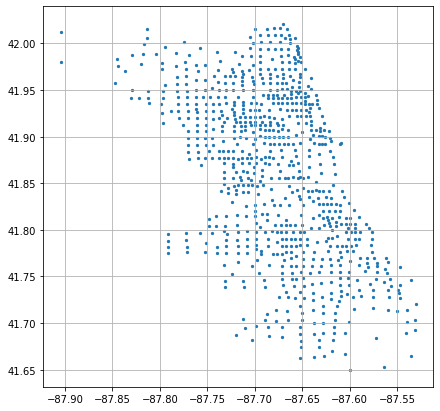

In [2]:
from shapely.wkt import loads as load_wkt

df_lu = pd.read_csv('../data/chicago/other/zone-lookup-taxi.csv')

poly_d = dict()
for r in df_lu.iterrows():
    poly = load_wkt(r[1]['the_geom'])
    zone = r[1]['NAME10']
    poly_d[zone] = (poly.centroid.x, poly.centroid.y)

df_zones = pd.DataFrame(data=poly_d, index=['longitude', 'latitude']).T
df_zones.sort_index(inplace=True)
df_zones.to_csv('../data/chicago/other/zone-centroids-taxi.csv')

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.scatter(*df_zones.values.T, s=5)
ax.grid()

df_zones.head()

### Nearest interpolation coverage

**Big caveat here!** `np.meshgrid -> indexing='xy'|'ij'`

- Using `indexing='xy'` (by default) returns a meshgrid with Cartesian indexing. This implies that indexing on the resulting array is reversed: `[j, i]`. If the inputs have length `M` and `N`, the outputs are of shape `(N, M)`.
- Using `indexing='ij'` returns a meshgrid with matrix indexing. This implies that indexing on the resulting array is "natural": `[i, j]`. If the inputs have length `M` and `N`, the outputs are of shape `(M, N)`.

Therefore, we can use `'xy'` indexing and then transpose the resulting arrays, or just use `'ij'` indexing.
Check `np.meshgrid` docs for more details.

In [33]:
from scipy.interpolate import griddata

def interp_map(arr, xy, X, Y, method='nearest', fill_value=np.nan):
    '''
    xy : Longitude and latitude of the available zones.
    X : x-coordinates of the mesh grid.
    Y : y-coordinates of the mesh grid.
    arr : Trip counts values used to interpolate.
    '''
    return griddata(xy, arr, (X, Y), method=method, fill_value=fill_value)

In [239]:
def check_coverage(df, map_dim, offset=0.005, xrange=None, yrange=None):
    xy = df.values
    x = xy[:, 0]
    y = xy[:, 1]
    if xrange is None or yrange is None:
        xrange = (x.min(), x.max())
        yrange = (y.min(), y.max())
        xstep, ystep = 0, 0
    else:
        xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
        ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
    xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
    ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
    X, Y = np.meshgrid(xnew, ynew, indexing='ij')
    interp = interp_map(df.index.values, df.values, X, Y, method='nearest')
    print(interp.shape)
    print('(x_step, y_step) = ({:.5f}, {:.5f})'.format(xnew[1] - xnew[0], ynew[1] - ynew[0]))
    print('(min_interp, max_interp) = ({}, {})'.format(interp.min().round(2), interp.max().round(2)))
    print('n_unique_interp = {}'.format(np.unique(interp).shape[0]))
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    axs[0].scatter(df.longitude, df.latitude, s=5)
    axs[0].set_xticks(xnew)
    axs[0].set_yticks(ynew)
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].grid()
    axs[1].imshow(interp.T, origin='lower')
    axs[2].hist(interp.ravel(), bins=30, edgecolor='k')
    plt.show()
    return X, Y, interp

(40, 40)
(x_step, y_step) = (0.00985, 0.00977)
(min_interp, max_interp) = (101.0, 9801.0)
n_unique_interp = 531


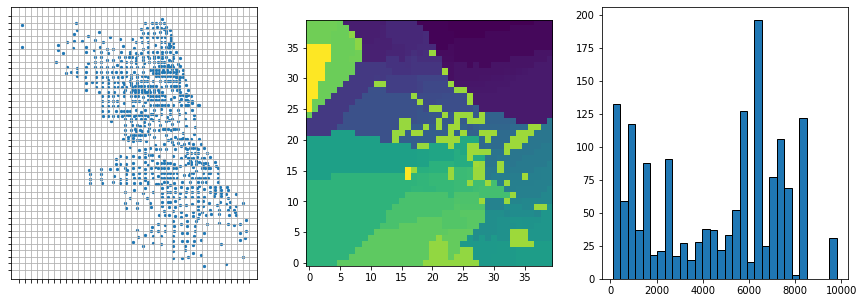

In [153]:
X, Y, interp = check_coverage(df_zones, (40, 40))

Here we take into account the bike racks that will be computed later on the notebook. The interpolation points of this grid are in the center of the bike grid:

(60, 90)
(x_step, y_step) = (0.00633, 0.00467)
(min_interp, max_interp) = (101.0, 9801.0)
n_unique_interp = 764


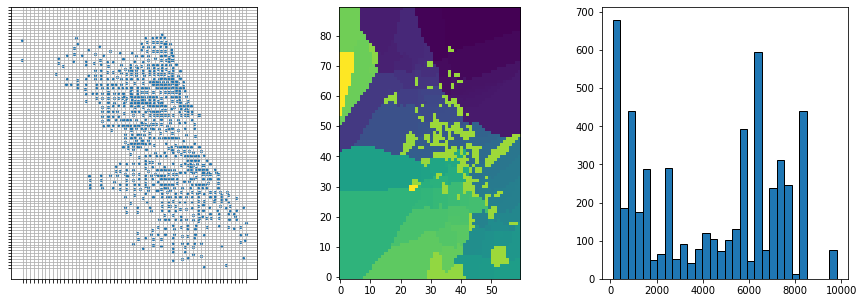

In [240]:
xrange = (df_locs.lng.min(), df_locs.lng.max())
yrange = (df_locs.lat.min(), df_locs.lat.max())
X, Y, interp = check_coverage(df_zones, (60, 90), offset=0.002, xrange=xrange, yrange=yrange)

Two zones in the west fall outside the grid, but it does not matter because there are grid points inside the convex hull that represent those points:

In [252]:
7706.02 in set(interp.ravel()), 9800.0 in set(interp.ravel())

(True, True)

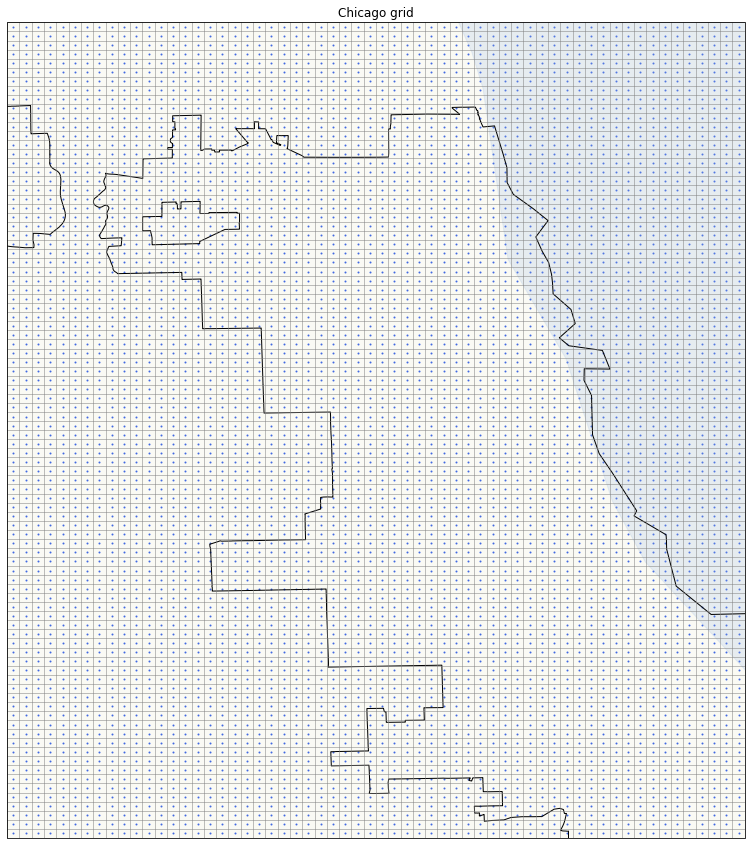

In [343]:
from shapely.ops import unary_union

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 15)
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.2)
lon_lat_ranges = [lng_intervals.min(), lng_intervals.max(), lat_intervals.min(), lat_intervals.max()]
ax.set_extent(lon_lat_ranges)
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
df_shp = pd.DataFrame({'zone': [r.attributes['name10'] for r in Reader(fname).records()],
                           'poly': Reader(fname).geometries()})
shape_feature = ShapelyFeature(unary_union(df_shp.poly), ccrs.PlateCarree(), edgecolor='k', facecolor='none')
ax.add_feature(shape_feature)
for lng in lng_intervals:
    ax.axvline(lng, color='grey', linewidth=0.5)
for lat in lat_intervals:
    ax.axhline(lat, color='grey', linewidth=0.5)
offset = 0.002
map_dim = (60, 90)
xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
ax.scatter(X, Y, color='royalblue', s=1)
ax.set_title('Chicago grid')
#ax.scatter(xnew[0], ynew[70])
#ax.scatter(*df_zones.loc[9800.0])
plt.show()

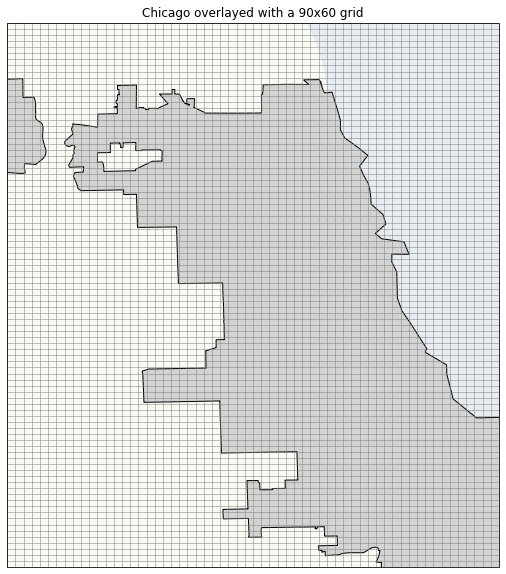

In [59]:
from shapely.ops import unary_union

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.2)
lon_lat_ranges = [lng_intervals.min(), lng_intervals.max(), lat_intervals.min(), lat_intervals.max()]
ax.set_extent(lon_lat_ranges)
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
df_shp = pd.DataFrame({'zone': [r.attributes['name10'] for r in Reader(fname).records()],
                           'poly': Reader(fname).geometries()})
shape_feature = ShapelyFeature(unary_union(df_shp.poly), ccrs.PlateCarree(), edgecolor='k', facecolor='lightgray')
ax.add_feature(shape_feature)
for idx, lng in enumerate(lng_intervals):
    ax.axvline(lng, color='grey', linewidth=0.5)
    #ax.text(lng, lat_intervals.max() - 0.01, s=idx)
for idx, lat in enumerate(lat_intervals):
    ax.axhline(lat, color='grey', linewidth=0.5)
    #ax.text(lng_intervals.max() - 0.01, lat, s=idx)
ax.set_extent(lon_lat_ranges)
ax.set_title('Chicago overlayed with a 90x60 grid')
plt.savefig('./graphs/chicago-grid.pdf', bbox_inches='tight')
plt.show()

### Build new dataset

In [34]:
def transfer_map(in_path, out_path, df, map_dim=(40, 40), offset=0.005, xrange=None, yrange=None):
    # Parameters for the output hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    # Prepare coordinates for interpolation
    xy = df.values
    x = xy[:, 0]
    y = xy[:, 1]
    if xrange is None or yrange is None:
        xrange = (x.min(), x.max())
        yrange = (y.min(), y.max())
        xstep, ystep = 0, 0
    else:
        xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
        ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
    xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
    ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
    X, Y = np.meshgrid(xnew, ynew, indexing='ij')
    tic = time.time()
    # Open file and transfer
    with tb.open_file(in_path, mode='r') as in_file, \
         tb.open_file(out_path, mode='a', filters=filters) as out_file, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for year in in_file.get_node('/'):
            # Load data for that year
            array = year[:, :]
            # Interpolate gaps (watch the axes order!)
            map_arr = interp_map(array.T, xy, X, Y, method='linear', fill_value=0).transpose((2, 1, 0))
            # Save to new hdf5 file
            node = out_file.create_carray(obj=map_arr, createparents=True,
                                          where='/', name=year._v_name)
            # Add meta: column names
            node._v_attrs['columns'] = in_file.get_node('/{}'.format(year._v_name))._v_attrs['columns']
            node._v_attrs['time_resolution'] = in_file.get_node('/{}'.format(year._v_name))._v_attrs['time_resolution']
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [4]:
df_zones = pd.read_csv('../data/chicago/other/zone_centroids.csv', index_col=0)

40 x 40 (not used anymore):

In [630]:
in_path = '../data/chicago/clean/chicago_pu_15m_count.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_40_40_count.h5'
transfer_map(in_path, out_path, df_zones)

'It took 00:03:39 in total'

In [635]:
in_path = '../data/chicago/clean/chicago_pu_15m_norm.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_40_40_norm.h5'
transfer_map(in_path, out_path, df_zones)

'It took 00:03:42 in total'

In [636]:
in_path = '../data/chicago/clean/chicago_pu_15m_stand.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_40_40_stand.h5'
transfer_map(in_path, out_path, df_zones)

'It took 00:01:25 in total'

In [5]:
in_path = '../data/chicago/clean/chicago_pu_15m_norm_abs.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_40_40_norm_abs.h5'
transfer_map(in_path, out_path, df_zones)

'It took 00:03:40 in total'

In [6]:
in_path = '../data/chicago/clean/chicago_pu_15m_stand_abs.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_40_40_stand_abs.h5'
transfer_map(in_path, out_path, df_zones)

'It took 00:03:53 in total'

50 x 80 (not used anymore):

In [96]:
in_path = '../data/chicago/clean/chicago_pu_15m_norm.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_50_80_norm.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(50, 80))

'It took 00:08:29 in total'

In [93]:
in_path = '../data/chicago/clean/chicago_pu_15m_stand.h5'
out_path = '../data/chicago/clean/chicago_pu_15m_map_50_80_stand.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(50, 80))

'It took 00:03:07 in total'

60 x 90:

In [35]:
xrange = (df_locs.lng.min(), df_locs.lng.max())
yrange = (df_locs.lat.min(), df_locs.lat.max())

In [19]:
in_path = '../data/chicago/clean/15m_flat_taxi_count.h5'
out_path = '../data/chicago/clean/15m_map_60_90_taxi_count.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(60, 90), offset=0.002, xrange=xrange, yrange=yrange)

'It took 00:10:32 in total'

In [20]:
in_path = '../data/chicago/clean/15m_flat_taxi_norm.h5'
out_path = '../data/chicago/clean/15m_map_60_90_taxi_norm.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(60, 90), offset=0.002, xrange=xrange, yrange=yrange)

'It took 00:10:40 in total'

In [21]:
in_path = '../data/chicago/clean/15m_flat_taxi_norm_abs.h5'
out_path = '../data/chicago/clean/15m_map_60_90_taxi_norm_abs.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(60, 90), offset=0.002, xrange=xrange, yrange=yrange)

'It took 00:10:37 in total'

Latest version:

In [36]:
in_path = '../data/chicago/clean/15m_flat_taxi_norm_abs.h5'
out_path = '../data/chicago/clean/15m_map_90_60_taxi_norm_abs.h5'
transfer_map(in_path, out_path, df_zones, map_dim=(60, 90), offset=0.002, xrange=xrange, yrange=yrange)

'It took 00:14:08 in total'

### Sanity checks

0.023809523809523808 -> 9.952380952380953


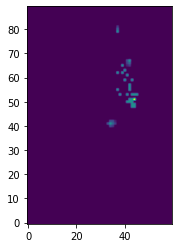

In [5]:
out_path = '../data/chicago/clean/15m_map_90_60_bike_norm_abs.h5'
#Starting from 2020 (idx 210336)
idx = 210336 + 24 * 5 + 4 * 14
with tb.open_file(out_path, mode='r') as in_file:
    map_arr = in_file.get_node('/2013')
    print(map_arr[idx].max(), '->' , map_arr[idx].max() * 418)
    plt.imshow(map_arr[idx], origin='lower')
    plt.plot()
plt.show()

In [41]:
xrange = (df_locs.lng.min(), df_locs.lng.max())
yrange = (df_locs.lat.min(), df_locs.lat.max())
xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])

In [50]:
ynew[53], xnew[44]

(41.896349438988565, -87.6245928649883)

(280512, 90, 60)
0.05719650852350304 -> 23.908140562824272 -> (50, 44)
0.0 -> 0.0 -> (0, 0)


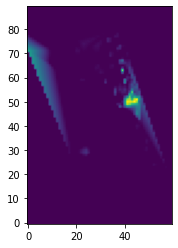

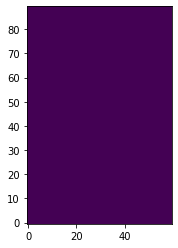

In [55]:
t = '../data/chicago/clean/15m_map_90_60_taxi_norm_abs.h5'
b = '../data/chicago/clean/15m_map_90_60_bike_norm_abs.h5'
#Starting from 2020 (idx 210336)
idx = 0 + 24 * 5 + 4 * 14 + 50
with tb.open_file(t, mode='r') as taxi, tb.open_file(b, mode='r') as bike:
    print(taxi.get_node('/2013').shape)
    map_t = taxi.get_node('/2013')[idx]
    print(map_t.max(), '->' , map_t.max() * 418, '->', np.unravel_index(map_t.argmax(), (90, 60)))
    plt.imshow(map_t*418, origin='lower')
    map_b = bike.get_node('/2013')[idx]
    print(map_b.max(), '->' , map_b.max() * 84, '->', np.unravel_index(map_b.argmax(), (90, 60)))
    plt.show()
    plt.imshow(map_b*84, origin='lower')

0.1582647937049448 -> 66.15468376866693


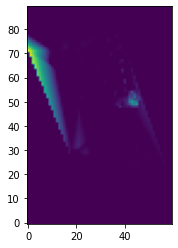

In [13]:
out_path = '../data/chicago/clean/15m_map_90_60_taxi_norm_abs.h5'
#Starting from 2020 (idx 210336)
idx = 210336 + 24 * 5 + 4 * 14
with tb.open_file(out_path, mode='r') as in_file:
    map_arr = in_file.get_node('/2013')
    print(map_arr[idx].max(), '->' , map_arr[idx].max() * 418)
    plt.imshow(map_arr[idx], origin='lower')
    plt.plot()
plt.show()

Using nearest neighbour interpolation, check that the interpolated array has the same values in a grid location near the airport as in the original data:

In [45]:
map_dim = (60, 90)
offset = 0.002
xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
X, Y = np.meshgrid(xnew, ynew, indexing='ij')
in_path = '../data/chicago/clean/15m_flat_taxi_count.h5'

with tb.open_file(in_path, mode='r') as in_file:
    year = in_file.get_node('/2013')[35040:2*35040, :]
    # Interpolate gaps (watch the axes order!)
    map_arr = interp_map(year.T, xy, X, Y, method='nearest').transpose((2, 0, 1))
    # Pick some instants:
    for instant in np.arange(40, 1000, 33):
        # The airport is the 799th zone, near node (0, 70) in a 60x90 map
        if year[instant, 799] != map_arr[instant, 0, 70]:
            print('Ouch!')

**Bonus**: 3D mobility map.

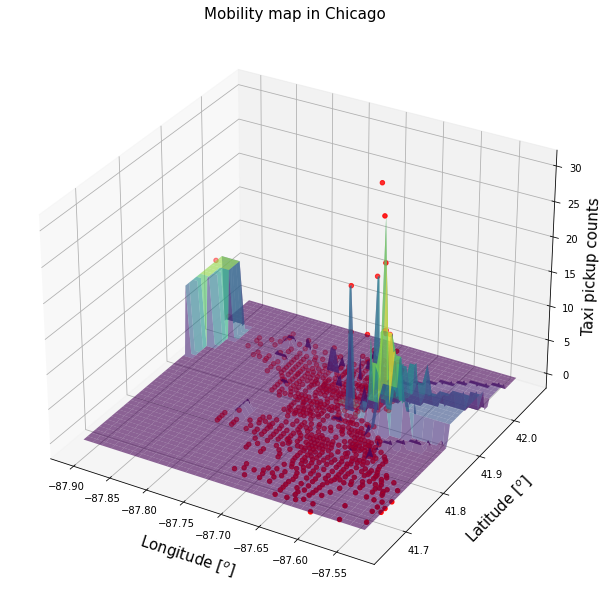

In [48]:
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure()
ax = p3.Axes3D(fig)
fig.set_size_inches(10, 8)
ax.set_xlabel(xlabel='Longitude [$^o$]', fontsize=15, labelpad=12)
ax.set_ylabel(ylabel='Latitude [$^o$]', fontsize=15, labelpad=12)
ax.set_zlabel(zlabel='Taxi pickup counts', fontsize=15)

instant = 40

ax.set_title('Mobility map in Chicago', fontsize=15)
ax.plot_surface(X, Y, map_arr[instant], cmap='viridis', alpha=0.6)
ax.scatter(x, y, year[instant], s=20, c='r')

plt.show()

# Chicago bikes

Raw data summary:
- **Number of files and size**: 3.3GB in 39 CSV files.
- **Time span**: 27th June 2013 - 2020.
- **Total number of trips**: almost 25 M.
- **Total number of stations**: 684.

In [4]:
df_zones = pd.read_csv('../data/chicago/other/zone-centroids-taxi.csv', index_col=0)
df_zones.columns = ['lng', 'lat']
df_zones.shape

(801, 2)

In [5]:
df_st = pd.read_csv('../data/chicago/other/station-locations-bike.csv', index_col=0)
df_st.shape

(684, 2)

In [6]:
df_locs = pd.concat([df_zones, df_st])

In [7]:
map_dim = (60, 90)
offset = 0.002
lng_intervals = np.linspace(df_locs.lng.min() - offset, df_locs.lng.max() + offset, map_dim[0] + 1)
lat_intervals = np.linspace(df_locs.lat.min() - offset, df_locs.lat.max() + offset, map_dim[1] + 1)

## Fetching the data

Started download on the 25th of January 2021:

In [2]:
url_d = {
    '2013': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Stations_Trips_2013.zip',
    '2014_Q1Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Stations_Trips_2014_Q1Q2.zip',
    '2014_Q3Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Stations_Trips_2014_Q3Q4.zip',
    '2015_Q1Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2015-Q1Q2.zip',
    '2015_Q3Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2015_Q3Q4.zip',
    '2016_Q1Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2016_Q1Q2.zip',
    '2016_Q3Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2016_Q3Q4.zip',
    '2017_Q1Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2017_Q1Q2.zip',
    '2017_Q3Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2017_Q3Q4.zip',
    '2018_Q1': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2018_Q1.zip',
    '2018_Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2018_Q2.zip',
    '2018_Q3': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2018_Q3.zip',
    '2018_Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2018_Q4.zip',
    '2019_Q1': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q1.zip',
    '2019_Q2': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q2.zip',
    '2019_Q3': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q3.zip',
    '2019_Q4': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q4.zip',
    '2020_Q1': 'https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2020_Q1.zip',
    '202004': 'https://divvy-tripdata.s3.amazonaws.com/202004-divvy-tripdata.zip',
    '202005': 'https://divvy-tripdata.s3.amazonaws.com/202005-divvy-tripdata.zip',
    '202006': 'https://divvy-tripdata.s3.amazonaws.com/202006-divvy-tripdata.zip',
    '202007': 'https://divvy-tripdata.s3.amazonaws.com/202007-divvy-tripdata.zip',
    '202008': 'https://divvy-tripdata.s3.amazonaws.com/202008-divvy-tripdata.zip',
    '202009': 'https://divvy-tripdata.s3.amazonaws.com/202009-divvy-tripdata.zip',
    '202010': 'https://divvy-tripdata.s3.amazonaws.com/202010-divvy-tripdata.zip',
    '202011': 'https://divvy-tripdata.s3.amazonaws.com/202011-divvy-tripdata.zip',
    '202012': 'https://divvy-tripdata.s3.amazonaws.com/202012-divvy-tripdata.zip'
}

In [14]:
for period in url_d.keys():
    print('Fechting {}...'.format(period))
    if os.path.exists('../data/chicago/raw/zips/{}_bikes.zip'.format(period)):
        continue
    r = requests.get(url_d[period])
    if r.status_code == 200:    
        with open('../data/chicago/raw/zips/{}_bikes.zip'.format(period), 'wb') as f:
            f.write(r.content)

Fechting 2013...
Fechting 2014_Q1Q2...
Fechting 2014_Q3Q4...
Fechting 2015_Q1Q2...
Fechting 2015_Q3Q4...
Fechting 2016_Q1Q2...
Fechting 2016_Q3Q4...
Fechting 2017_Q1Q2...
Fechting 2017_Q3Q4...
Fechting 2018_Q1...
Fechting 2018_Q2...
Fechting 2018_Q3...
Fechting 2018_Q4...
Fechting 2019_Q1...
Fechting 2019_Q2...
Fechting 2019_Q3...
Fechting 2019_Q4...
Fechting 2020_Q1...
Fechting 202004...
Fechting 202005...
Fechting 202006...
Fechting 202007...
Fechting 202008...
Fechting 202009...
Fechting 202010...
Fechting 202011...
Fechting 202012...


In [939]:
!ls ../data/chicago/raw/zips/*.zip | wc -l

27


After unzipping and moving the files that record the bike rides:

In [4]:
!du -ch ../data/chicago/raw/*ivvy*

14M	../data/chicago/raw/202004-divvy-tripdata.csv
33M	../data/chicago/raw/202005-divvy-tripdata.csv
59M	../data/chicago/raw/202006-divvy-tripdata.csv
94M	../data/chicago/raw/202007-divvy-tripdata.csv
106M	../data/chicago/raw/202008-divvy-tripdata.csv
92M	../data/chicago/raw/202009-divvy-tripdata.csv
67M	../data/chicago/raw/202010-divvy-tripdata.csv
45M	../data/chicago/raw/202011-divvy-tripdata.csv
24M	../data/chicago/raw/202012-divvy-tripdata.csv
90M	../data/chicago/raw/Divvy_Trips_2013.csv
107M	../data/chicago/raw/Divvy_Trips_2014_Q1Q2.csv
49M	../data/chicago/raw/Divvy_Trips_2014-Q3-07.csv
83M	../data/chicago/raw/Divvy_Trips_2014-Q3-0809.csv
54M	../data/chicago/raw/Divvy_Trips_2014-Q4.csv
63M	../data/chicago/raw/Divvy_Trips_2015_07.csv
59M	../data/chicago/raw/Divvy_Trips_2015_08.csv
51M	../data/chicago/raw/Divvy_Trips_2015_09.csv
25M	../data/chicago/raw/Divvy_Trips_2015-Q1.csv
106M	../data/chicago/raw/Divvy_Trips_2015-Q2.csv
77M	../data/chicago/raw/Divvy_Trips_2015_Q4.csv
28M	../data/

In [291]:
!head -2 ../data/chicago/raw/Divvy_Trips_2020_Q1.csv

In [31]:
df_colnames = pd.DataFrame(columns=['shape', 'columns', 'n_pickup', 'n_dropoff'])
for file in glob.glob('../data/chicago/raw/*ivvy*.csv'):
    df = pd.read_csv(file)
    period = os.path.basename(file).replace('Divvy_Trips_', '').replace('-divvy-tripdata', '').replace('.csv', '')
    #print(period)
    df_colnames.loc[period, 'shape'] = df.shape
    df_colnames.loc[period, 'columns'] = str(df.columns.values)
    try:
        df_colnames.loc[period, 'n_pickup'] = df.start_station_id.nunique()
    except AttributeError:
        try:
            df_colnames.loc[period, 'n_pickup'] = df.from_station_id.nunique()
        except AttributeError:
            df_colnames.loc[period, 'n_pickup'] = df['03 - Rental Start Station ID'].nunique()
    try:
        df_colnames.loc[period, 'n_dropoff'] = df.end_station_id.nunique()
    except AttributeError:
        try:
            df_colnames.loc[period, 'n_dropoff'] = df.to_station_id.nunique()
        except AttributeError:
            df_colnames.loc[period, 'n_dropoff'] = df['02 - Rental End Station ID'].nunique()

In [55]:
df_colnames.sort_index()

,shape,columns,n_pickup,n_dropoff
2013,"(759788, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2014-Q3-07,"(410340, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2014-Q3-0809,"(700630, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2014-Q4,"(437965, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2014_Q1Q2,"(905699, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2015-Q1,"(202349, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,300,300
2015-Q2,"(893890, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,470,470
2015_07,"(533711, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,474,474
2015_08,"(495029, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,475,475
2015_09,"(427095, 12)",['trip_id' 'starttime' 'stoptime' 'bikeid' 'tr...,475,475


In [56]:
df_colnames.sort_index().to_excel('../data/chicago/other/bikes_colnames.xlsx')

25M of entries in total:

In [51]:
sum([df_colnames.loc[period, 'shape'][0] for period in df_colnames.index])

24785027

Column headers differ between files:

In [52]:
df_colnames['columns'].nunique()

5

**Caveat**:
- December 2020 contains some really bad start statation IDs, so we set those values to NaN in 2.3.2.
- Some stations changed location along time, but almost always this change was below 500m (so our map is a good approximation).
- Notice also that column types need to be specified when reading the `csv`s.

## Prepare stations lookup file

First, extract station locations from the provided look-up files. These periods don't include `(lng, lat)` in the trip information:
- 2013,
- 2014 Q1Q2,
- 2014 Q3Q4,
- 2015,
- 2016 Q1Q2,
- 2016 Q3,
- 2016 Q4,
- 2017 Q1Q2, and
- 2017 Q3Q4.

In [918]:
lookup_files = [
    'Divvy_Stations_Trips_2013/Divvy_Stations_2013.csv',
    'Divvy_Stations_Trips_2014_Q3Q4/Divvy_Stations_2014-Q3Q4.csv',
    'Divvy_Stations_2015.csv',
    'Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
    'Divvy_Stations_2016_Q3.csv',
    'Divvy_Stations_2016_Q4.csv',
    'Divvy_Stations_2017_Q1Q2.csv',
    'Divvy_Stations_2017_Q3Q4.csv',
]
cols = ['id', 'name', 'longitude', 'latitude']

base = '../data/chicago/raw/zips/'
df_stations_lookup = pd.read_excel(base + 'Divvy_Stations_2014-Q1Q2.xlsx')[cols]

for f in lookup_files:
    df_stations_lookup = pd.concat([df_stations_lookup, pd.read_csv(base + f)[cols]])

# Remove lng-lat from (Temp) stations (later they are dropped):
df_stations_lookup.loc[df_stations_lookup.name.str.contains('(Temp)', regex=False),
                       ['longitude', 'latitude']] = np.nan
# Remove (*) from station names:
df_stations_lookup.loc[:, 'name'] = df_stations_lookup.name.str.replace(' (*)', '', regex=False)
df_stations_lookup.columns = cols = ['id', 'name', 'lng', 'lat']
# Clean up:
df_stations_lookup.sort_values('id', inplace=True)
df_stations_lookup.reset_index(inplace=True, drop=True)
df_stations_lookup.drop_duplicates(inplace=True)
df_stations_lookup.dropna(subset=['lng', 'lat'], inplace=True)
# Check:
print('Number of unique station ids:', df_stations_lookup.id.nunique())
print('Number of unique station ids + long-lat-name:', df_stations_lookup.shape[0])
print('Number of unique station ids which are duplicated:',
      df_stations_lookup[df_stations_lookup.duplicated('id', keep=False)].id.nunique())
# Keep full data for a later check:
df_full = df_stations_lookup.copy()

Number of unique station ids: 586
Number of unique station ids + long-lat-name: 1106
Number of unique station ids which are duplicated: 303


Group-by `id` and compute mean of `(lng, lat)` in order to obtain unique stations:

In [800]:
df_stations_lookup = df_stations_lookup.groupby('id')[['lng', 'lat']].mean()
print('Shape:', df_stations_lookup.shape[0])
df_stations_lookup.head()

Shape: 586


,lng,lat
id,,
2,-87.622371,41.875010
3,-87.615355,41.867226
4,-87.613348,41.856268
5,-87.627732,41.873990
6,-87.612795,41.885042


For 2020, `(lng, lat)` is included within the trip information directly:

In [921]:
start_id = ['start_station_id', 'from_station_id', '03 - Rental Start Station ID']
end_id = ['end_station_id', 'to_station_id', '02 - Rental End Station ID']
start_name = ['from_station_name', 'start_station_name', '03 - Rental Start Station Name']
end_name = ['to_station_name', 'end_station_name', '02 - Rental End Station Name']
start_lng = ['start_lng']
start_lat = ['start_lat']
end_lng = ['end_lng']
end_lat = ['end_lat']

#colnames = ['id', 'name', 'longitude', 'latitude']
df_stations = pd.DataFrame(columns=['id', 'name', 'lng', 'lat'])

for file in glob.glob('../data/chicago/raw/*ivvy*.csv'):
    if '2020' not in file or '202012' in file:
        continue # December 2020 has bad data so we skip it
    df = pd.read_csv(file)
    # START STATION
    cols = []
    colnames = []
    for kind, colname in [(start_id, 'id'), (start_name, 'name'), (start_lng, 'lng'), (start_lat, 'lat')]:
        for c in kind:
            if c in df.columns:
                cols.append(c)
                colnames.append(colname)
    # Once we know the cols, extract them and include them:
    aux = df[cols].drop_duplicates()
    aux.columns = colnames
    df_stations = pd.concat([df_stations, aux])
    # END STATION
    cols = []
    colnames = []
    for kind, colname in [(end_id, 'id'), (end_name, 'name'), (end_lng, 'lng'), (end_lat, 'lat')]:
        for c in kind:
            if c in df.columns:
                cols.append(c)
                colnames.append(colname)
    aux = df[cols].drop_duplicates()
    aux.columns = colnames
    df_stations = pd.concat([df_stations, aux])

df_stations.dropna(subset=['id'], inplace=True)
# Remove lng-lat from (Temp) stations (later they are dropped):
df_stations.loc[df_stations.name.str.contains('(Temp)', regex=False), ['lng', 'lat']] = np.nan
# Remove (*) from station names:
df_stations.loc[:, 'name'] = df_stations.name.str.replace(' (*)', '', regex=False)
# Clean up:
df_stations.id = df_stations.id.astype(int)
df_stations.name = df_stations.name.astype(str)
df_stations.lng = df_stations.lng.astype(float)
df_stations.lat = df_stations.lat.astype(float)
df_stations.sort_values('id', inplace=True)
# Now drop duplicates and exclude ids with NaNs:
df_stations_lookup.dropna(subset=['lng', 'lat'], inplace=True)
df_stations.drop_duplicates(inplace=True)
df_stations.reset_index(inplace=True, drop=True)
# Keep full data for a later check
df_full = pd.concat([df_full, df_stations.copy()])
df_stations.shape

(732527, 4)

Group-by `id` and compute mean of `(lng, lat)` in order to obtain unique stations:

In [866]:
df_stations = df_stations.groupby('id')[['lng', 'lat']].mean()
print('Shape:', df_stations.shape[0])
df_stations.head()

Shape: 669


,lng,lat
id,,
2,-87.620377,41.876304
3,-87.615349,41.867193
4,-87.613117,41.855954
5,-87.627653,41.874043
6,-87.612832,41.886906


Combine the two dataframes, prioritizing the look-up stations:

In [878]:
missing_lookup = set(df_stations.index).difference(set(df_stations_lookup.index))
print('The look-up files miss {} ids'.format(len(missing_lookup)))
df_st = pd.concat([df_stations_lookup, df_stations.loc[missing_lookup]])
df_st.sort_index(inplace=True)
print('Final shape:', df_st.shape[0])
df_st.head()

The look-up files miss 98 ids
Final shape: 684


,lng,lat
id,,
2,-87.622371,41.875010
3,-87.615355,41.867226
4,-87.613348,41.856268
5,-87.627732,41.873990
6,-87.612795,41.885042


Now, for years 2018 and 2019, no additional look-up files are provided, nor `(lng, lat)` information is included in the trip information. Check that we are covered:

In [894]:
start_id = ['start_station_id', 'from_station_id', '03 - Rental Start Station ID']
end_id = ['end_station_id', 'to_station_id', '02 - Rental End Station ID']

st_set = set()
aux = pd.DataFrame()

for file in glob.glob('../data/chicago/raw/*ivvy*.csv'):
    if '2018' not in file and '2019' not in file:
        continue
    df = pd.read_csv(file)
    for colname in start_id + end_id:
        try:
            st_set = st_set.union(set(df[colname].unique()))
            aux = pd.concat([aux, df[df[colname].isin([1, 360, 361, 363, 512, 669])]])
        except KeyError:
            pass

The following stations don't have a location at all:

In [883]:
st_set.difference(set(df_st.index))

{1, 360, 361, 363, 512, 669}

It seems like they all/most of them refer to Divvy repair stations:

In [909]:
aux[aux['02 - Rental End Station ID'].isin([1, 360, 361, 363, 512, 669])]\
    [['02 - Rental End Station ID', '02 - Rental End Station Name']].drop_duplicates()

,02 - Rental End Station ID,02 - Rental End Station Name
212369,361.0,DIVVY CASSETTE REPAIR MOBILE STATION
450289,360.0,DIVVY Map Frame B/C Station
483232,1.0,Special Events
877299,669.0,LBS - BBB La Magie
460009,363.0,TS ~ DIVVY PARTS TESTING
134432,512.0,BBB ~ Divvy Parts Testing


Therefore, we are ready to save the station locations:

In [917]:
df_st.to_csv('../data/chicago/other/station-locations-bike.csv')

As a final check, compute distance between moving stations:

In [929]:
print(df_full.shape)
df_full.drop_duplicates(inplace=True)
df_full.dropna(subset=['lng', 'lat'], inplace=True)
print(df_full.shape)
df_full.groupby('id').size().max()

(733633, 4)
(732975, 4)


6896

In [938]:
stations = df_full.loc[df_full.duplicated('id', keep='first'), 'id'].unique()
dist = pd.DataFrame(index=stations, columns=range(6896), dtype=float)
for st in stations:
    aux = df_full[df_full.id == st].reset_index(drop=True).copy()
    for r in range(aux.shape[0] - 1):
        dist.loc[st, r] = distance.distance(aux.loc[0, ['lng', 'lat']],
                                            aux.loc[r+1, ['lng', 'lat']]).m
dist.to_csv('../data/chicago/other/duplicate-stations-bike.csv')

Closer look:

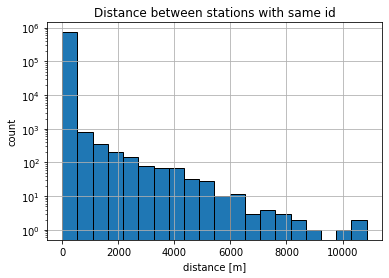

In [944]:
dist_arr = dist.values.ravel()
dist_arr = dist_arr[~np.isnan(dist_arr)]
plt.hist(dist_arr, bins=20, edgecolor='k')
plt.title('Distance between stations with same id')
plt.xlabel('distance [m]')
plt.ylabel('count')
plt.yscale('log')
plt.grid()
plt.show()

In [955]:
(dist.loc[missing_multiple].mean(axis=1) - dist.loc[missing_multiple].median(axis=1)).sort_values().tail(10)

663      16.550165
638      17.956574
644      18.357978
653      18.598879
639      19.457989
631      23.931918
717      49.071347
725     197.231257
709     622.566119
704    1600.045938
dtype: float64

Stations 704, 709, and 725 seem to contain some outliers:

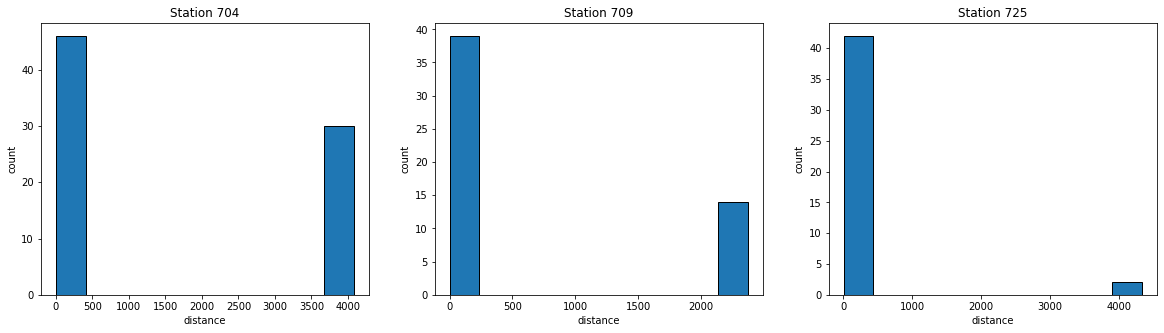

In [971]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
axs = axs.ravel()
for idx, st in enumerate([704, 709, 725]):
    ax[idx].hist(dist.loc[st], edgecolor='k')
    ax[idx].set_title('Station {}'.format(st))
    ax[idx].set_ylabel('count')
    ax[idx].set_xlabel('distance')
plt.show()

Finally, a plot showing the taxi zone centroids and the bike stations:

Centroid of all points for the weather: [-87.66742067  41.86597867]
Centroid of all points for the weather (rounded by meteoblue): -87.67 41.87


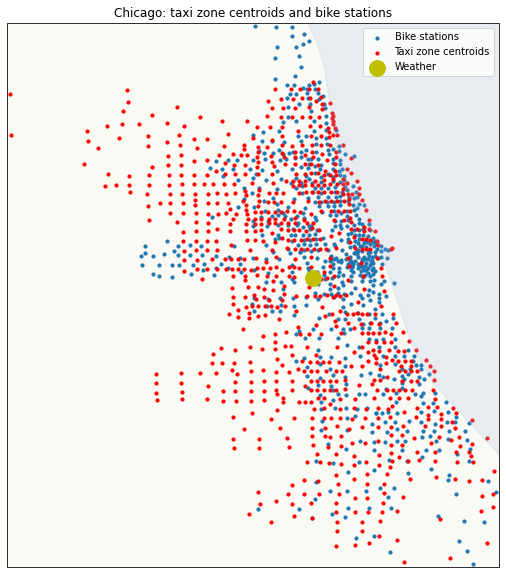

In [315]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.2)
lon_lat_ranges = [lng_intervals.min(), lng_intervals.max(), lat_intervals.min(), lat_intervals.max()]
ax.set_extent(lon_lat_ranges)
fig.set_size_inches(10, 10)
ax.scatter(df_st.lng, df_st.lat, s=10, label='Bike stations')
ax.scatter(df_zones.longitude, df_zones.latitude, s=10, c='r', label='Taxi zone centroids')
weather_centroid = np.concatenate([df_zones.values, df_st.values]).mean(axis=0)
print('Centroid of all points for the weather:', weather_centroid)
print('Centroid of all points for the weather (rounded by meteoblue):', -87.67, 41.87)
#ax.scatter(*weather_centroid, s=300, c='g', label='Weather (centroid)')
#ax.scatter([-87.67], [41.87], s=300, c='y', label='Weather (rounded)')
ax.scatter([-87.67], [41.87], s=250, c='y', label='Weather')
ax.set_aspect('equal')
ax.set_title('Chicago: taxi zone centroids and bike stations')
ax.legend(loc='upper right')
#ax.grid()
#plt.savefig('./graphs/taxi-bike-weather-chicago.pdf', bbox_inches='tight')
plt.show()

## Process and transfer raw trips

### Checks

For the first years (2013-2017), check that the lookup file contains all ids and that ids are not duplicated on them:

In [77]:
d_lu = {'../data/chicago/raw/Divvy_Trips_2013.csv': 'Divvy_Stations_Trips_2013/Divvy_Stations_2013.csv',
        '../data/chicago/raw/Divvy_Trips_2014-Q3-07.csv': 'Divvy_Stations_Trips_2014_Q3Q4/Divvy_Stations_2014-Q3Q4.csv',
        '../data/chicago/raw/Divvy_Trips_2014-Q3-0809.csv': 'Divvy_Stations_Trips_2014_Q3Q4/Divvy_Stations_2014-Q3Q4.csv',
        '../data/chicago/raw/Divvy_Trips_2014-Q4.csv': 'Divvy_Stations_Trips_2014_Q3Q4/Divvy_Stations_2014-Q3Q4.csv',
        '../data/chicago/raw/Divvy_Trips_2014_Q1Q2.csv': 'Divvy_Stations_2014-Q1Q2.xlsx',
        '../data/chicago/raw/Divvy_Trips_2015-Q1.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2015-Q2.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2015_07.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2015_08.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2015_09.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2015_Q4.csv': 'Divvy_Stations_2015.csv',
        '../data/chicago/raw/Divvy_Trips_2016_04.csv': 'Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2016_05.csv': 'Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2016_06.csv': 'Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2016_Q1.csv': 'Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2016_Q3.csv': 'Divvy_Stations_2016_Q3.csv',
        '../data/chicago/raw/Divvy_Trips_2016_Q4.csv': 'Divvy_Stations_2016_Q4.csv',
        '../data/chicago/raw/Divvy_Trips_2017_Q1.csv': 'Divvy_Stations_2017_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2017_Q2.csv': 'Divvy_Stations_2017_Q1Q2.csv',
        '../data/chicago/raw/Divvy_Trips_2017_Q3.csv': 'Divvy_Stations_2017_Q3Q4.csv',
        '../data/chicago/raw/Divvy_Trips_2017_Q4.csv': 'Divvy_Stations_2017_Q3Q4.csv'
        }

In [1218]:
base_lu = '../data/chicago/raw/zips/'
for file in sorted(glob.glob('../data/chicago/raw/*ivvy*.csv')):
    if '2018' in file or '2019' in file or '2020' in file:
        continue
    df = pd.read_csv(file)
    period = os.path.basename(file).replace('Divvy_Trips_', '').replace('.csv', '')
    #print(period)
    if 'csv' in d_lu[file]:
        df_lu = pd.read_csv(base_lu + d_lu[file])
    else:
        df_lu = pd.read_excel(base_lu + d_lu[file])
    if set(df.from_station_id.unique()) <= set(df_lu.id):
        print('alright!', period)
    else:
        print('wrong!', period)
    if df_lu.id.nunique() != df_lu.shape[0]:
        print('duplicated look-up ids for', period)

alright! 2013
alright! 2014-Q3-07
alright! 2014-Q3-0809
alright! 2014-Q4
alright! 2014_Q1Q2
alright! 2015-Q1
alright! 2015-Q2
alright! 2015_07
wrong! 2015_08
wrong! 2015_09
wrong! 2015_Q4
alright! 2016_04
alright! 2016_05
alright! 2016_06
alright! 2016_Q1
alright! 2016_Q3
alright! 2016_Q4
alright! 2017_Q1
alright! 2017_Q2
alright! 2017_Q3
alright! 2017_Q4


In those 3 cases, 394 is missing in the corresponding look-up file:

In [1211]:
df_st.loc[394]

lng   -87.631246
lat    41.870816
Name: 394, dtype: float64

### Build new dataset

The final file will look like this:
```
chicago_bikes.h5 (file)
|-- years (carray) -> bike rides: time + station (rows) + lng-lat (columns)
```

In [192]:
cols = ['id', 'longitude', 'latitude']
colnames = ['timestamp', 'id', 'lng', 'lat']

start_id = ['start_station_id', 'from_station_id', '03 - Rental Start Station ID']
start_time = ['starttime', 'start_time', 'started_at', '01 - Rental Details Local Start Time']

base_lu = '../data/chicago/raw/zips/'
na_count = 0
df_st_master = df_st.reset_index().copy()

filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
out_path = '../data/chicago/clean/01s_flat_bike_raw.h5'
tic = time.time()
with tb.open_file(out_path, mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    for year in range(2013, 2021):
        print('Working on {}...'.format(year))
        df_year = pd.DataFrame()
        for file in sorted(glob.glob('../data/chicago/raw/*ivvy*.csv')):
            if str(year) not in file:# or '202012' in file:
                continue # 202012 has bad data
            df = pd.read_csv(file)
            for st_id in start_id:
                if st_id in df.columns:
                    break
            for st_time in start_time:
                if st_time in df.columns:
                    break
            df[st_time] = pd.to_datetime(df[st_time])
            period = os.path.basename(file).replace('Divvy_Trips_', '').replace('.csv', '')
            #print(period)
            # Case 1: using lookup files
            if file in d_lu.keys():
                df = df[[st_time, st_id]]
                df.columns = colnames[:2]
                if 'csv' in d_lu[file]:
                    df_lu = pd.read_csv(base_lu + d_lu[file])[cols]
                else:
                    df_lu = pd.read_excel(base_lu + d_lu[file])[cols]
                df_lu.columns = colnames[1:]
                na_count += df.shape[0]
                df = pd.merge(df, df_lu, how='left')
                df.dropna(subset=['id', 'lng', 'lat'], inplace=True)
                na_count -= df.shape[0]
            # Case 2: using lng-lat directly
            elif 'start_lng' in df.columns and 'start_lat' in df.columns:
                df = df[[st_time, st_id, 'start_lng', 'start_lat']]
                df.columns = colnames
                na_count += df.shape[0]
                if '202012' in file:
                    df.id = np.nan # IDs are wrong in this case
                    # For this month, there is 1 trip outside of the map, which we remove
                    df = df[df.lat <= 42.066765548888895]
                    df.dropna(subset=['lng', 'lat'], inplace=True)
                else:
                    df.dropna(subset=['id', 'lng', 'lat'], inplace=True)
                na_count -= df.shape[0]
            # Case 3: using look-up master file
            else:
                df = df[[st_time, st_id]]
                df.columns = colnames[:2]
                na_count += df.shape[0]
                df = pd.merge(df, df_st_master, how='left')
                df.dropna(subset=['id', 'lng', 'lat'], inplace=True)
                na_count -= df.shape[0]
            df_year = pd.concat([df_year, df])
        id_nan = df_year.id.isna().sum() > 0
        if id_nan:
            print('{} has some NaNs on the ID field'.format(year))
        df_year.timestamp = df_year.timestamp.astype('int64') // 1e9
        node = hdf5_file.create_carray(obj=df_year.values,# atom=dtype,
                                       where='/', name='{:04}'.format(year))
        # Add meta: column names, id_nan
        node._v_attrs['columns'] = colnames
        node._v_attrs['some_ids_are_nan'] = id_nan
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Working on 2013...


/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...
2020 has some NaNs on the ID field
It took 00:18:21 in total


In [193]:
print('{} trips were excluded, which is the {:0.4f}%'.format(na_count, na_count / 24785027 * 100))

84986 trips were excluded, which is the 0.3429%


Check total number of trips:

In [194]:
trip_count = 0
with tb.open_file(out_path, mode='r', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    for year in range(2013, 2021):
        trip_count += hdf5_file.root['{}'.format(year)].shape[0]
trip_count == (24785027 - na_count)

True

### Convert to 15min

In [305]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
in_path = '../data/chicago/clean/01s_flat_bike_raw.h5'

tic = time.time()
with tb.open_file(in_path, mode='r', filters=filters) as hdf5_in, \
     tb.open_file(in_path.replace('01s', '15m'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    df_full = pd.DataFrame()
    time_ints_cum = 0
    for year in range(2013, 2021):
        print('Working on {}...'.format(year))
        # Load year
        node_in = hdf5_in.root['{}'.format(year)]
        df = pd.DataFrame(data=node_in[:])
        # Convert time since epoch to datetime
        df[0] = pd.to_datetime(df[0], unit='s')
        # Bin time, longitude and latitude
        time_intervals = pd.date_range('1/1/{}'.format(year), '1/1/{}'.format(year+1), freq='15T')
        df[0] = pd.cut(df[0], time_intervals, right=False,
                       labels=range(time_ints_cum, time_ints_cum + len(time_intervals) - 1))
        time_ints_cum += time_intervals.shape[0] - 1
        df_full = pd.concat([df_full, df])
    df_full.sort_values(0, inplace=True)
    node = hdf5_file.create_carray(obj=df_full.values,# atom=dtype,
                                   where='/', name='2013')
    # Add meta: column names, id_nan
    aux = node_in._v_attrs['columns']
    aux[0] = 'time_int'
    node._v_attrs['columns'] = aux
    node._v_attrs['some_ids_are_nan'] = node_in._v_attrs['some_ids_are_nan']
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...
It took 00:01:07 in total


In [308]:
trip_count = 0
with tb.open_file(in_path.replace('01s', '15m'), mode='r', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    trip_count += hdf5_file.root['2013'].shape[0]
trip_count == (24785027 - na_count)

True

## Convert to trip counts per cell

In [11]:
lng_intervals = np.linspace(df_locs.lng.min() - offset, df_locs.lng.max() + offset, map_dim[0] + 1)
lat_intervals = np.linspace(df_locs.lat.min() - offset, df_locs.lat.max() + offset, map_dim[1] + 1)

filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
in_path = '../data/chicago/clean/15m_flat_bike_raw.h5'
cols = ['time_int', 'lng_int', 'lat_int']

tic = time.time()
with tb.open_file(in_path, mode='r', filters=filters) as hdf5_in, \
     tb.open_file(in_path.replace('raw', 'count'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    # Load data
    df = pd.DataFrame(data=hdf5_in.root['2013'][:], columns=['time_int', 'id', 'lng', 'lat'])
    # Bin longitude and latitude
    df['lng_int'] = pd.cut(df.lng, lng_intervals, right=False, labels=range(len(lng_intervals) - 1))
    df['lat_int'] = pd.cut(df.lat, lat_intervals, right=False, labels=range(len(lat_intervals) - 1))
    # Prepare sorted version of the dataframe
    aux = df[cols].sort_values(cols, ignore_index=True).copy()#.set_index(cols).copy()
    aux['cell'] = aux.lng_int.astype(str).str.zfill(2) + '_' + aux.lat_int.astype(str).str.zfill(2)
    # Location of the cells
    locs = aux[['lng_int', 'lat_int']].drop_duplicates().sort_values(['lng_int', 'lat_int'])
    # Keep grid locations that we use for future reference:
    locs.to_csv('../data/chicago/other/grid-locations-bike.csv', index=False)
    df_pivot = aux[['time_int', 'cell']].pivot_table(index='time_int', columns='cell', aggfunc=len, fill_value=0)
    # Convert counts to int, and reindex to fill empty time intervals with 0
    df_pivot = df_pivot.astype('int16').reindex(range(280512), fill_value=0)
    # 280512 is the total number of 15min intervals between 2013 and 2020
    node = hdf5_file.create_carray(obj=df_pivot.values, where='/', name='2013')
    # Add meta: column names
    node._v_attrs['columns'] = df_pivot.columns.values
    node._v_attrs['time_resolution'] = '15min'
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

In [460]:
print('Final shape', df_pivot.shape)
print('Total number of trips:', df_pivot.sum().sum())
print('Maximum number of trips in a cell during 15min:', df_pivot.max().max())

Final shape (280512, 857)
Total number of trips: 24700041
Maximum number of trips in a cell during 15min: 84


Normalize using 84 as the max:

In [462]:
maxi = 84
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
in_path = '../data/chicago/clean/15m_flat_bike_count.h5'

tic = time.time()
with tb.open_file(in_path, mode='r', filters=filters) as hdf5_in, \
     tb.open_file(in_path.replace('count', 'norm'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    # Load data
    arr = hdf5_in.root['2013'][:]
    arr = arr / maxi
    node = hdf5_file.create_carray(obj=arr, where='/', name='2013')
    # Add meta: column names
    node._v_attrs['columns'] = df_pivot.columns.values
    node._v_attrs['time_resolution'] = '15min'
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:04:34 in total


In [468]:
print('Final shape', arr.shape)
print('Maximum value in a cell during 15min:', arr.max())

Final shape (280512, 857)
Maximum value in a cell during 15min: 1.0


## Mobility map

### Checks 

Combine taxi zones and bike racks to check map extent:

In [152]:
df_zones.columns = ['lng', 'lat']
df_locs = pd.concat([df_zones, df_st])
offset = 0.002

lng_dist = distance.distance((df_locs.lat.iloc[0], df_locs.lng.min() - offset),
                             (df_locs.lat.iloc[0], df_locs.lng.max() + offset))
print('Distance between min & max longitude: {:0.2f}km'.format(lng_dist.km))
lat_dist = distance.distance((df_locs.lat.min() - offset, df_locs.lng.iloc[0]),
                             (df_locs.lat.max() + offset, df_locs.lng.iloc[0]))
print('Distance between min & max latitude: {:0.2f}km'.format(lat_dist.km))
print()
print('for a 40 x 40 map ({} nodes):'.format(40 * 40))
print('for longitude: {:0.2f}m'.format(lng_dist.m / 40))
print('for latitude: {:0.2f}m'.format(lat_dist.m / 40))
print()
print('for a 50 x 80 map ({} nodes):'.format(50 * 80))
print('for longitude: {:0.2f}m'.format(lng_dist.m / 50))
print('for latitude: {:0.2f}m'.format(lat_dist.m / 80))
print()
print('for a 60 x 90 map ({} nodes):'.format(60 * 90))
print('for longitude: {:0.2f}m'.format(lng_dist.m / 60))
print('for latitude: {:0.2f}m'.format(lat_dist.m / 90))
print()
print('for a 30 x 45 map ({} nodes):'.format(30 * 45))
print('for longitude: {:0.2f}m'.format(lng_dist.m / 30))
print('for latitude: {:0.2f}m'.format(lat_dist.m / 45))

Distance between min & max longitude: 31.48km
Distance between min & max latitude: 46.67km

for a 40 x 40 map (1600 nodes):
for longitude: 786.99m
for latitude: 1166.81m

for a 50 x 80 map (4000 nodes):
for longitude: 629.59m
for latitude: 583.40m

for a 60 x 90 map (5400 nodes):
for longitude: 524.66m
for latitude: 518.58m

for a 30 x 45 map (1350 nodes):
for longitude: 1049.32m
for latitude: 1037.16m


Check that all trips fall within the map limits:

In [461]:
in_path = '../data/chicago/clean/15m_flat_bike_raw.h5'
with tb.open_file(in_path, mode='r', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    arr = hdf5_file.root['2013'][:]
    lng_min, lng_max = sum(arr[:, 2] < df_locs.lng.min() - offset),\
                       sum(arr[:, 2] > df_locs.lng.max() + offset)
    if lng_min > 0 or lng_max > 0:
        print(year, 'lng', lng_min, lng_max)
    lat_min, lat_max = sum(arr[:, 3] < df_locs.lat.min() - offset),\
                       sum(arr[:, 3] > df_locs.lat.max() + offset)
    if lat_min > 0 or lat_max > 0:
        print(year, 'lat', lat_min, lat_max)

### Build new dataset 

We take the locations `locs` of the cells from the previous section 2.4:

In [469]:
map_dim = (60, 90)
offset = 0.002

# Locations of taxi zone centroids + bike racks
xrange = (df_locs.lng.min(), df_locs.lng.max())
yrange = (df_locs.lat.min(), df_locs.lat.max())
xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
X, Y = np.meshgrid(xnew, ynew, indexing='ij')

# Locations of cells with counts > 0
locs['lng'] = locs.lng_int.map(dict(zip(range(60), xnew)))
locs['lat'] = locs.lat_int.map(dict(zip(range(90), ynew)))
xy = locs[['lng', 'lat']].values
x = xy[:, 0]
y = xy[:, 1]

Now, transform into a map of shape `(time, lat_int, lng_int) -> (280512, 90, 60)`:

In [470]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
out_path = '../data/chicago/clean/15m_flat_bike_norm_abs.h5'

tic = time.time()
with tb.open_file(out_path, mode='r', filters=filters) as hdf5_in, \
     tb.open_file(out_path.replace('flat', 'map_90_60'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    # Load data
    arr = hdf5_in.root['2013'][:]
    # Interpolate gaps
    # Watch the axis order! (time, row, column) -> (time, lat, lng)
    map_arr = interp_map(arr.T, xy, X, Y, method='linear', fill_value=0).transpose((2, 1, 0))
    node = hdf5_file.create_carray(obj=map_arr, where='/', name='2013')
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:10:40 in total


In [471]:
print('Final shape', map_arr.shape)
print('Maximum value in a cell during 15min:', map_arr.max())

Final shape (280512, 90, 60)
Maximum value in a cell during 15min: 1.0


Sample mobility map:

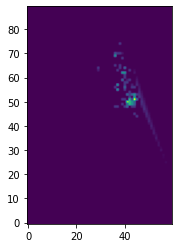

0.07142857142857142 -> 6.0


In [476]:
#Starting from 2020 (idx 210336)
idx = 210336 + 24 * 5 + 4 * 12
plt.imshow(map_arr[idx], origin='lower')
plt.show()
print(map_arr[idx].max(), '->' , map_arr[idx].max() * 84)

### Old way

#### Build new dataset

Now, transform into a map of shape `(time, lat_int, lng_int) -> (35040, 90, 60)`:

In [125]:
map_dim = (60, 90)
lng_intervals = np.linspace(df_locs.lng.min() - offset, df_locs.lng.max() + offset, map_dim[0] + 1)
lat_intervals = np.linspace(df_locs.lat.min() - offset, df_locs.lat.max() + offset, map_dim[1] + 1)

filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
out_path = '../data/chicago/clean/chicago_bikes_raw.h5'
cols = ['time_int', 'lng_int', 'lat_int']

tic = time.time()
with tb.open_file(out_path, mode='r', filters=filters) as hdf5_in, \
     tb.open_file(out_path.replace('raw', '15m_map_60_90_count'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    for year in range(2013, 2021):
        print('Working on {}...'.format(year))
        # Load year
        df = pd.DataFrame(data=hdf5_in.root['{}'.format(year)][:])
        # Convert time since epoch to datetime
        df[0] = pd.to_datetime(df[0], unit='s')
        # Bin time, longitude and latitude
        time_intervals = pd.date_range('1/1/{}'.format(year), '1/1/{}'.format(year+1), freq='15T')
        df['time_int'] = pd.cut(df[0], time_intervals, right=False, labels=range(len(time_intervals) - 1))
        df['lng_int'] = pd.cut(df[2], lng_intervals, right=False, labels=range(len(lng_intervals) - 1))
        df['lat_int'] = pd.cut(df[3], lat_intervals, right=False, labels=range(len(lat_intervals) - 1))
        # Prepare sorted version of the dataframe
        aux = df[cols].sort_values(cols, ignore_index=True).set_index(cols).copy()
        # Group-by index and count
        aux_g = aux.groupby(aux.index).size()
        # Obtain indexes from the grouped df index
        indexes = np.array(list(aux_g.index.values))
        # Instantiate empty mobility map
        mob_map = np.zeros((time_intervals.nunique() - 1, map_dim[1], map_dim[0]))
        # Watch the axis order! (time, row, column) -> (time, lat, lng)
        mob_map[indexes[:, 0], indexes[:, 2], indexes[:, 1]] = aux_g.values
        node = hdf5_file.create_carray(obj=mob_map,# atom=dtype,
                                       where='/', name='{:04}'.format(year))
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...
It took 00:02:23 in total


Check excluded trips:

In [133]:
total = 0
maxi = 0
orig_total = [759788, 2454634, 3183439, 3595383, 3829014, 3603082, 3818004, 3541683]
with tb.open_file(out_path.replace('raw', '15m_map_60_90_count'), mode='r', filters=filters) as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        aux = hdf5_file.root['/{}'.format(year)][:].sum()
        print(year, '->', int(aux), '({:0.2f}%)'.format(aux / orig_total[idx] * 100))
        total += aux
        if hdf5_file.root['/{}'.format(year)][:].max() > maxi:
            maxi = hdf5_file.root['/{}'.format(year)][:].max()
print('Total->',  int(total), '({:0.2f}%)'.format(total / 24653454 * 100))
print('Global maximum ->', maxi)

2013 -> 759788 (100.00%)
2014 -> 2454634 (100.00%)
2015 -> 3182286 (99.96%)
2016 -> 3595383 (100.00%)
2017 -> 3829014 (100.00%)
2018 -> 3602864 (99.99%)
2019 -> 3817973 (100.00%)
2020 -> 3326527 (93.93%)
Total-> 24568469 (99.66%)
Global maximum -> 84.0


Sample mobility map:

10.0


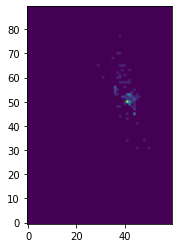

In [82]:
with tb.open_file(out_path.replace('raw', '15m_map_60_90_count'), mode='r', filters=filters) as hdf5_file:
    idx = 24 * 5 + 12
    plt.imshow(hdf5_file.root['/{}'.format(year)][idx], origin='lower')
    print(hdf5_file.root['/{}'.format(year)][idx].max())

#### Normalise

We saw that the global maximum is 84, so we use it to normalise the dataset:

In [140]:
maxi = 84.0

tic = time.time()
with tb.open_file(out_path.replace('raw', '15m_map_60_90_count'), mode='r', filters=filters) as hdf5_in, \
     tb.open_file(out_path.replace('raw', '15m_map_60_90_norm_abs'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    warnings.simplefilter('ignore', tb.NaturalNameWarning)
    for year in range(2013, 2021):
        print('Working on {}...'.format(year))
        node = hdf5_file.create_carray(obj=hdf5_in.root['{}'.format(year)][:] / maxi,
                                       where='/', name='{:04}'.format(year))
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...
It took 00:05:01 in total


Maximum per year:

In [142]:
with tb.open_file(out_path.replace('raw', '15m_map_60_90_norm'), mode='r', filters=filters) as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        print('{} -> {:0.4f}'.format(year, hdf5_file.root['/{}'.format(year)][:].max()))

2013 -> 0.3690
2014 -> 0.6071
2015 -> 0.5833
2016 -> 0.6667
2017 -> 0.7381
2018 -> 0.8571
2019 -> 1.0000
2020 -> 0.4762


Sample mobility map:

0.11904761904761904


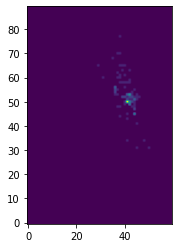

In [143]:
with tb.open_file(out_path.replace('raw', '15m_map_60_90_norm'), mode='r', filters=filters) as hdf5_file:
    idx = 24 * 5 + 12
    plt.imshow(hdf5_file.root['/{}'.format(year)][idx], origin='lower')
    print(hdf5_file.root['/{}'.format(year)][idx].max())

# Chicago weather

Raw data summary:
- **Number of files and size**: 4.6MB in 8 CSV files.
- **Time span**: 2013 to 2020.
- **Variables**: 8
- **Location**: `(41.86597867, -87.66742067)`
- **Time zone:** CST (-06:00)

## Fetching the data

Weather variables can be found [here](https://content.meteoblue.com/en/specifications/weather-variables), and history data [here](https://www.meteoblue.com/en/weather/archive/export).

In [8]:
!du -ch ../data/chicago/raw/weather_2*

580K	../data/chicago/raw/weather_2013.csv
580K	../data/chicago/raw/weather_2014.csv
580K	../data/chicago/raw/weather_2015.csv
580K	../data/chicago/raw/weather_2016.csv
580K	../data/chicago/raw/weather_2017.csv
580K	../data/chicago/raw/weather_2018.csv
580K	../data/chicago/raw/weather_2019.csv
580K	../data/chicago/raw/weather_2020.csv
4.6M	total


Sample data:

In [17]:
!head -n 12 ../data/chicago/raw/weather_2013.csv

location,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W,41.87°N 87.67°W
lat,41.99986,41.99986,41.99986,41.99986,41.99986,41.99986,41.99986,41.99986
lon,-87.65625,-87.65625,-87.65625,-87.65625,-87.65625,-87.65625,-87.65625,-87.65625
asl,188.244,188.244,188.244,188.244,188.244,188.244,188.244,188.244
variable,Temperature,Precipitation Total,Snowfall Amount,Relative Humidity,Wind Speed,Wind Direction,Cloud Cover Total,Shortwave Radiation
unit,°C,mm,cm,%,km/h,°,%,W/m²
level,2 m elevation corrected,sfc,sfc,2 m,10 m,10 m,sfc,sfc
resolution,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly
aggregation,None,None,None,None,None,None,None,None
timestamp,41.87°N 87.67°W Temperature [2 m elevation corrected],41.87°N 87.67°W Precipitation Total,41.87°N 87.67°W Snowfall Amount,41.87°N 87.67°W Relative Humidity [2 m],41.87°N 87.67°W Wind Speed [10 m],41.87°N 87.67°W Wind Direction [10 m],41.87°N 87.67°W Cloud Cover Total,41.87°N 8

## Process and transfer weather data 

In [52]:
def conv_wind(df, w_speed, w_dir):
    # First, convert direction to radians
    wd_rad = df[w_dir] * np.pi / 180
    # Now, calculate the wind X and Y components (and convert from km/h to m/s)
    df[w_speed] = df[w_speed] * np.cos(wd_rad) / 3600 * 1000
    df[w_dir] = df[w_speed] * np.sin(wd_rad) / 3600 * 1000
    return df

In [53]:
def transfer_raw(in_path, out_path, coltypes):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    #dtype = tb.Int16Atom()
    tic = time.time()
    df_full = pd.DataFrame()
    for year in url_d.keys():
        file = in_path.format(year)
        print('Working on {}...'.format(year))
        df = pd.read_csv(file, skiprows=9, dtype=coltypes, parse_dates=[0])
        if df.timestamp.diff().dropna().unique().shape[0] != 1:
            print('timestamp problems!')
            break
        # Convert wind speed and direction to wind vector
        w_speed = '41.87°N 87.67°W Wind Speed [10 m]'
        w_dir = '41.87°N 87.67°W Wind Direction [10 m]'
        df = conv_wind(df, w_speed, w_dir)
        df_full = pd.concat([df_full, df])
    # Open file and transfer
    with tb.open_file(out_path, mode='a', filters=filters) as hdf5_file, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)    
        node = hdf5_file.create_carray(obj=df_full[coltypes.keys()].values,# atom=dtype,
                                       where='/', name='2013')
        # Add meta:
        cols = [c.replace('41.87°N 87.67°W ', '') for c in coltypes.keys()]
        cols[4], cols[5] = 'Wind X [10 m]', 'Wind Y [10 m]'
        node._v_attrs['columns'] = cols
        node._v_attrs['units'] = ['°C', 'mm', 'cm', '%', 'm/s', 'm/s', '%', 'W/m²']
        #node._v_attrs['units'] = ['°C', 'mm', 'cm', '%', 'km/h', '°', '%', 'W/m²']
        node._v_attrs['location'] = '41.87°N 87.67°W '
        node._v_attrs['time_resolution'] = '1h'
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [54]:
coltypes = {
    #'timestamp': 'datetime64[ns]',
    '41.87°N 87.67°W Temperature [2 m elevation corrected]': float,
    '41.87°N 87.67°W Precipitation Total': float,
    '41.87°N 87.67°W Snowfall Amount': float,
    '41.87°N 87.67°W Relative Humidity [2 m]': float,
    '41.87°N 87.67°W Wind Speed [10 m]': float,
    '41.87°N 87.67°W Wind Direction [10 m]': float,
    '41.87°N 87.67°W Cloud Cover Total': float,
    '41.87°N 87.67°W Shortwave Radiation': float
}

In [55]:
in_path = '../data/chicago/raw/weather_{}.csv'
out_path = '../data/chicago/clean/chicago_weather_1h.h5'
transfer_raw(in_path, out_path, coltypes)

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...


'It took 00:00:00 in total'

## Checks

Check wind vector:

/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  key = numpy.array(key)


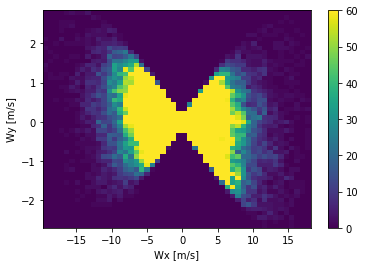

In [56]:
with tb.open_file(out_path, mode='r') as hdf5_file:
    year = 2013
    arr = hdf5_file.get_node('/{:04}'.format(year))[:, [4, 5]]
plt.hist2d(arr[:, 0], arr[:, 1], bins=(50, 50), vmax=60)
plt.colorbar()
plt.xlabel('Wx [m/s]')
plt.ylabel('Wy [m/s]')
plt.show()

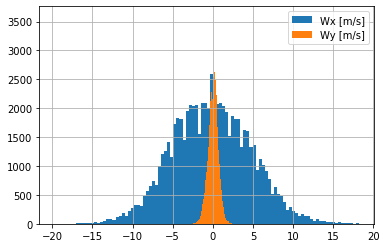

In [57]:
plt.hist(arr[:, 0], bins=100, label='Wx [m/s]')
plt.hist(arr[:, 1], bins=100, label='Wy [m/s]')
plt.legend()
plt.grid()
plt.show()

## Normalise

$$x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$

In [62]:
file = '../data/chicago/raw/weather_1985_2020.csv'
df = pd.read_csv(file, skiprows=9, dtype=coltypes, parse_dates=[0])
# Convert wind speed and direction to wind vector
w_speed = '41.87°N 87.67°W Wind Speed [10 m]'
w_dir = '41.87°N 87.67°W Wind Direction [10 m]'
df = conv_wind(df, w_speed, w_dir)
cols = df.columns.values
cols[5], cols[6] = 'Wind X [10 m]', 'Wind Y [10 m]'
df.columns = cols
df.describe().T

,count,mean,std,min,25%,50%,75%,max
41.87°N 87.67°W Temperature [2 m elevation corrected],315576.0,10.690476,11.471217,-34.479416,1.240586,10.790586,20.170586,42.010586
41.87°N 87.67°W Precipitation Total,315576.0,0.089131,0.465630,0.000000,0.000000,0.000000,0.000000,24.900000
41.87°N 87.67°W Snowfall Amount,315576.0,0.000584,0.021903,0.000000,0.000000,0.000000,0.000000,2.800000
41.87°N 87.67°W Relative Humidity [2 m],315576.0,68.387311,19.235851,8.000000,54.000000,70.000000,84.000000,100.000000
Wind X [10 m],315576.0,-0.066978,5.056601,-19.700001,-3.700000,-0.100000,3.500000,23.899998
Wind Y [10 m],315576.0,0.029038,0.658122,-3.290204,-0.372678,0.055404,0.454887,3.188132
41.87°N 87.67°W Cloud Cover Total,315576.0,55.875117,44.702059,0.000000,5.000000,69.000000,100.000000,100.000000
41.87°N 87.67°W Shortwave Radiation,315576.0,176.447955,247.798602,0.000000,0.000000,12.460000,306.160000,956.750000


In [63]:
mini, maxi = df.iloc[:, 1:].min().values, df.iloc[:, 1:].max().values

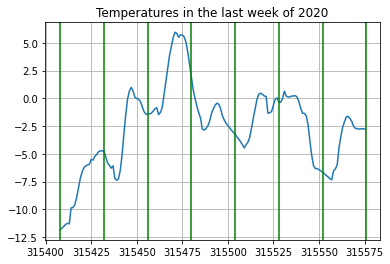

In [64]:
df.iloc[-24*7:, 1].plot()
for i in range(8):
    plt.axvline(df.iloc[-24*7:].index[0] + 24 * i, c='g')
plt.grid()
plt.gca().set_title('Temperatures in the last week of 2020')
plt.show()

In [65]:
filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
dtype = tb.Float16Atom()

with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('.h5', '_norm.h5'), mode='a', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    year= 2013
    arr = hdf5_in.get_node('/{:04}'.format(year))[:] 
    arr = (arr - mini) / (maxi - mini)
    node = hdf5_file.create_carray(obj=arr,# atom=dtype,
                                  where='/', name='{:04}'.format(year))
    # Add meta:
    node._v_attrs['columns'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['columns']
    node._v_attrs['units'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['units']
    node._v_attrs['location'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['location']
    node._v_attrs['time_resolution'] = hdf5_in.get_node('/{:04}'.format(year))._v_attrs['time_resolution']

/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2013'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Checks:

In [68]:
cols = ['temperature min',
        'temperature max',
        'precipitation min',
        'precipitation max',
        'snowfall min',
        'snowfall max',
        'humidity min',
        'humidity max',
        'wind_X min',
        'wind_X max',
        'wind_Y min',
        'wind_Y max',
        'cloud_cover min',
        'cloud_cover max',
        'radiation min',
        'radiation max']

In [69]:
df_stat = pd.DataFrame(columns=cols)
with tb.open_file(out_path, mode='r') as hdf5_in, \
     tb.open_file(out_path.replace('.h5', '_norm.h5'), mode='r', filters=filters) as hdf5_file, \
     warnings.catch_warnings() as w:
    year = 2013
    arr1 = hdf5_in.get_node('/{:04}'.format(year))[:]
    arr2 = hdf5_file.get_node('/{:04}'.format(year))[:]
    df_stat.loc[str(year), 'temperature min'::2] = arr1.min(axis=0)
    df_stat.loc[str(year), 'temperature max'::2] = arr1.max(axis=0)
    df_stat.loc[str(year) + ' norm', 'temperature min'::2] = arr2.min(axis=0)
    df_stat.loc[str(year) + ' norm', 'temperature max'::2] = arr2.max(axis=0)
print(df_stat.iloc[1::2].values.min(), df_stat.iloc[1::2].values.max())
df_stat.T

0.0 1.0


,2013,2013 norm
temperature min,-34.479416,0.000000
temperature max,36.110584,0.922866
precipitation min,0.000000,0.000000
precipitation max,24.900000,1.000000
snowfall min,0.000000,0.000000
snowfall max,2.800000,1.000000
humidity min,11.000000,0.032609
humidity max,100.000000,1.000000
wind_X min,-19.699998,0.000000
wind_X max,18.199999,0.869266


# NYC taxi

Raw data summary:
- **Number of files and size**: 291GB in 280 files.
- **Time span**: 2009 - 2019.
- **Total number of trips**: > 2600 M.
- **Total number of zones**: 263.
- **Taxi services and types of locations**:
  - yellow:
    - 2009-01 - 2016-06: longitude and latitude.
    - 2016-07 - 2016-12: unknown (few PULocations and many DOLocations).
    - 2017-01 - 2019-12: zones.
  - green:
    - 2013-08 - 2016-06: longitude and latitude.
    - 2016-07 - 2016-12: unknown (few PULocations and many DOLocations).
    - 2017-01 - 2019-12: zones.
  - fhv:
    - 2015-01 - 2016-12: zones (no drop-off).
    - 2017-01 - 2019-12: zones.
  - fhvhv:
    - 2019-02 - 2019-12: zones.

## Fetching the data

URL format:
- Yellow taxis: `'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv'`
- Green taxis: `'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-01.csv'`
- FHV taxis: `'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2019-03.csv'`
- FHVHV taxis: `'https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2019-02.csv'`

In [245]:
url_d = {
    'yellow': 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{:04}-{:02}.csv',
    'green': 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_{:04}-{:02}.csv',
    'fhv': 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_{:04}-{:02}.csv',
    'fhvhv': 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_{:04}-{:02}.csv'
}

years = range(2009, 2020)
months = range(1, 13)
taxis = ['yellow', 'green', 'fhv', 'fhvhv']

Started download on the 19th of June 2020, finished on the 23rd of June 2020:

In [247]:
for year in years:
    print('Fechting {}...'.format(year))
    for month in months:
        for taxi in taxis:
            if os.path.exists('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi)):
                continue
            r = requests.get(url_d[taxi].format(year, month))
            if r.status_code == 200:
                with open('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi), 'wb') as f:
                    f.write(r.content)

Fechting 2009...
Fechting 2010...
Fechting 2011...
Fechting 2012...
Fechting 2013...
Fechting 2014...
Fechting 2015...
Fechting 2016...
Fechting 2017...
Fechting 2018...
Fechting 2019...


In [3]:
!ls ../data/nyc/raw/ | wc -l

280


In [4]:
!du -h ../data/nyc/raw/

291G	../data/nyc/raw/


In [253]:
!head -1 ../data/nyc/raw/201902_fhvhv.csv

In [325]:
!head -5 ../data/nyc/raw/201902_fhv.csv

In [ ]:
idx = pd.MultiIndex.from_product([years, months, taxis], names=['year', 'month', 'taxi'])
df_colnames = pd.DataFrame(index=idx, columns=['shape', 'columns', 'n_pickup', 'n_dropoff',
                                               'n_pickup_long_lat', 'n_dropoff_long_lat'])

In [256]:
for year in years:
    for month in months:
        for taxi in taxis:
            if not os.path.exists('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi)):
                continue
            df = pd.read_csv('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi), error_bad_lines=False)
            df.columns = df.columns.str.strip()
            df_colnames.loc[(year, month, taxi), 'shape'] = df.shape
            df_colnames.loc[(year, month, taxi), 'columns'] = str(df.columns.values)
            if 'PULocationID' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup'] = df['PULocationID'].nunique()
                df_colnames.loc[(year, month, taxi), 'n_dropoff'] = df['DOLocationID'].nunique()
            elif 'PUlocationID' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup'] = df['PUlocationID'].nunique()
                df_colnames.loc[(year, month, taxi), 'n_dropoff'] = df['DOlocationID'].nunique()
            elif 'locationID' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup'] = df['locationID'].nunique()
            elif 'Start_Lon' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup_long_lat'] = (df['Start_Lon'].astype(str) + ', ' + df['Start_Lat'].astype(str)).nunique()
                df_colnames.loc[(year, month, taxi), 'n_dropoff_long_lat'] = (df['End_Lon'].astype(str) + ', ' + df['End_Lat'].astype(str)).nunique()
            elif 'pickup_longitude' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup_long_lat'] = (df['pickup_longitude'].astype(str) + ', ' + df['pickup_latitude'].astype(str)).nunique()
                df_colnames.loc[(year, month, taxi), 'n_dropoff_long_lat'] = (df['dropoff_longitude'].astype(str) + ', ' + df['dropoff_latitude'].astype(str)).nunique()
            elif 'Pickup_longitude' in df.columns:
                df_colnames.loc[(year, month, taxi), 'n_pickup_long_lat'] = (df['Pickup_longitude'].astype(str) + ', ' + df['Pickup_latitude'].astype(str)).nunique()
                df_colnames.loc[(year, month, taxi), 'n_dropoff_long_lat'] = (df['Dropoff_longitude'].astype(str) + ', ' + df['Dropoff_latitude'].astype(str)).nunique()


In [285]:
df_colnames.dropna(how='all').sort_values(['year', 'month'])

shape  \
year month taxi                     
2009 1     yellow  (14092413, 18)   
     2     yellow  (13380122, 18)   
     3     yellow  (14387371, 18)   
     4     yellow  (14294783, 18)   
     5     yellow  (14796313, 18)   
...                           ...   
2019 11    fhvhv    (21635508, 7)   
     12    yellow   (6896317, 18)   
           green     (450627, 20)   
           fhv       (1759399, 6)   
           fhvhv    (22243149, 7)   

                                                             columns n_pickup  \
year month taxi                                                                 
2009 1     yellow  ['vendor_name' 'Trip_Pickup_DateTime' 'Trip_Dr...      NaN   
     2     yellow  ['vendor_name' 'Trip_Pickup_DateTime' 'Trip_Dr...      NaN   
     3     yellow  ['vendor_name' 'Trip_Pickup_DateTime' 'Trip_Dr...      NaN   
     4     yellow  ['vendor_name' 'Trip_Pickup_DateTime' 'Trip_Dr...      NaN   
     5     yellow  ['vendor_name' 'Trip_Pickup_DateTime' 'Trip_Dr...      NaN   
...                                                              ...      ...   
2019 11    fhvhv   ['hvfhs_license_num' 'dispatching_base_num' 'p...      261   
     12    yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...      261   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...      256   
           fhv     ['dispatching_base_num' 'pickup_datetime' 'dro...      261   
           fhvhv   ['hvfhs_license_num' 'dispatching_base_num' 'p...      262   

                  n_dropoff n_pickup_long_lat n_dropoff_long_lat  
year month taxi                                                   
2009 1     yellow       NaN          13297284           13458194  
     2     yellow       NaN          12673858           12815968  
     3     yellow       NaN          13619754           13785617  
     4     yellow       NaN          13495236           13665743  
     5     yellow       NaN          13937781           14122180  
...                     ...               ...                ...  
2019 11    fhvhv        262               NaN                NaN  
     12    yellow       261               NaN                NaN  
           green        260               NaN                NaN  
           fhv          263               NaN                NaN  
           fhvhv        261               NaN                NaN  

[280 rows x 6 columns]

In [263]:
#df_colnames.to_excel('../data/nyc/other/nyc_colnames.xlsx')
df_colnames.dropna(how='all').sort_values(['year', 'month']).to_excel('../data/nyc/other/nyc_colnames.xlsx')

2617M of entries in total:

In [332]:
sum([df_colnames.loc[r, 'shape'][0] for r in df_colnames.dropna(how='all').index])

2617776856

## Next